In [1]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd

# 한글폰트 지정
plt.rcParams['font.family'] = 'AppleGothic'

# 한글폰트 사용 시 -기호 깨지는 문제 해결
plt.rcParams['axes.unicode_minus']=False

In [2]:
orders_data = pd.read_csv('orders_data.csv', dtype={'customer_zip_code_prefix': str})
items_data = pd.read_csv('items_data.csv', dtype={'seller_zip_code_prefix': str})

In [3]:
orders_data['order_approved_date'] = pd.to_datetime(orders_data['order_approved_date'])
orders_data['order_delivered_date'] = pd.to_datetime(orders_data['order_delivered_date'])
orders_data['order_estimated_date'] = pd.to_datetime(orders_data['order_estimated_date'])

# 2️⃣ 숫자 컬럼(float) 변환 (결측치 제거 전)
num_cols = ['customer_lat','customer_lng','total_item_price','total_freight','avg_review_score']
for col in num_cols:
    orders_data[col] = pd.to_numeric(orders_data[col], errors='coerce')

In [4]:
# 결측치 제거
orders_data = orders_data[orders_data['order_status']=='delivered']
orders_data = orders_data.dropna(subset=['order_approved_date'])
orders_data = orders_data.dropna(subset=['order_delivered_date'])
orders_data = orders_data.dropna(subset=['customer_lat'])
orders_data = orders_data.dropna(subset=['customer_lng'])
orders_data = orders_data.dropna(subset=['avg_review_score'])
items_data = items_data.dropna(subset=['seller_lat'])
items_data = items_data.dropna(subset=['seller_lng'])
itmes_data = items_data.dropna(subset=['review_score'])

In [9]:

# =====================
# 1️⃣ 원본 보존
# =====================
orders = orders_data.copy()
items = items_data.copy()

# =====================
# 2️⃣ 좌표 결측/범위 이상치 제거
# =====================
df2 = items.merge(
    orders[['order_id','customer_lat','customer_lng']],
    on='order_id',
    how='inner'
)

df2 = df2[
    df2["seller_lat"].between(-35, 10) &
    df2["seller_lng"].between(-75, -30) &
    df2["customer_lat"].between(-35, 10) &
    df2["customer_lng"].between(-75, -30) ]



# =====================
# # 2.5️⃣ price 이상치 제거 (IQR 기준)
# # =====================
# Q3 = df2['price'].quantile(0.75)
# IQR = Q3 - Q1

# # 상위값만 제거
# df2 = df2[df2['price'] <= Q3 + 1.5*IQR]



# =====================
# 3️⃣ 거리 계산 (상품 단위)
# =====================
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df2['distance_km'] = haversine_vec(
    df2['seller_lat'], df2['seller_lng'],
    df2['customer_lat'], df2['customer_lng']
)

# =====================
# 4️⃣ 주문 단위 집계
# =====================
order_distance_sum = df2.groupby('order_id', as_index=False)['distance_km'] \
                          .sum().rename(columns={'distance_km':'order_distance_km_sum'})
order_distance_mean = df2.groupby('order_id', as_index=False)['distance_km'] \
                           .mean().rename(columns={'distance_km':'order_distance_km_mean'})
order_distance_median = df2.groupby('order_id', as_index=False)['distance_km'] \
                             .median().rename(columns={'distance_km':'order_distance_km_median'})
order_freight_sum = df2.groupby('order_id', as_index=False)['freight_value'] \
                          .sum().rename(columns={'freight_value':'order_freight_sum'})
n_shipments = df2.groupby('order_id', as_index=False)['seller_id'] \
                   .nunique().rename(columns={'seller_id':'n_shipments'})



# 예시: 'price'가 상품 단가 컬럼이라 가정
order_total_price = df2.groupby('order_id', as_index=False)['price'].sum() \
                         .rename(columns={'price':'order_total_price'})
# =====================
# 5️⃣ 배송기간 & 지연 플래그
# =====================
orders['delivery_days'] = (orders['order_delivered_date'] - orders['order_approved_date']).dt.days
orders['delivery_delay_days'] = (orders['order_delivered_date'] - orders['order_estimated_date']).dt.days

# =====================
# 6️⃣ 최종 Merge
# =====================
orders_enriched = orders.merge(order_distance_sum, on='order_id', how='left') \
                        .merge(order_distance_mean, on='order_id', how='left') \
                        .merge(order_distance_median, on='order_id', how='left') \
                        .merge(order_freight_sum, on='order_id', how='left') \
                        .merge(n_shipments, on='order_id', how='left')\
                        .merge(order_total_price, on='order_id', how='left')


# =====================


# =====================
# 8️⃣ state_summary 생성 (전체 주문 기준 지연율)
# =====================
total_orders = len(orders_enriched)

state_summary_total = (
    orders_enriched
    .groupby('customer_state')
    .agg(
        orders=('order_id', 'nunique'),
        median_price=('order_total_price', 'median'),
        late_rate= ('delivery_delay_days', lambda x: (x > 0).mean() * 100)
    )
    .reset_index()
)

state_summary_total['late_rate'] = state_summary_total['late_rate'].round(2)

# =====================
# 9️⃣ 파레토 프런티어 계산
# =====================
def pareto_frontier(df, maximize=['orders','median_price','late_rate'], minimize=[]):
    is_pareto = np.ones(df.shape[0], dtype=bool)
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            if i == j:
                continue
            better_or_equal_max = all(row_j[m] >= row_i[m] for m in maximize)
            better_or_equal_min = all(row_j[m] <= row_i[m] for m in minimize)
            strictly_better = any(row_j[m] > row_i[m] for m in maximize) or any(row_j[m] < row_i[m] for m in minimize)
            if better_or_equal_max and better_or_equal_min and strictly_better:
                is_pareto[i] = False
                break
    return df[is_pareto]

pareto_candidates = pareto_frontier(
    state_summary_total,
    maximize=['orders','median_price','late_rate'],
    minimize=[]
)

# 결과 확인
pareto_candidates


customer_state  orders  median_price  late_rate
0              AC      80       119.000       3.75
1              AL     393       107.800      20.87
4              BA    3221        93.990      11.83
5              CE    1268        99.900      13.72
9              MA     708        98.700      16.95
13             PA     931       105.000      10.74
14             PB     510       110.000      10.20
15             PE    1575        99.000       9.40
16             PI     468       109.945      13.89
18             RJ   12196        89.990      11.94
21             RR      41       122.990      12.20
25             SP   40247        79.800       4.44

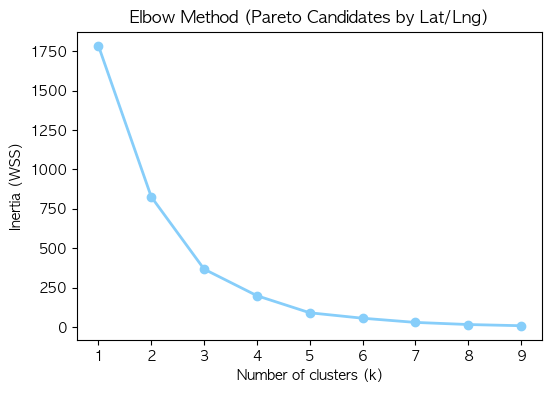

In [76]:
# =====================
# 1️⃣ 주별 평균 좌표 구하기
# =====================
state_coords = (
    orders_enriched.groupby('customer_state')
    .agg(
        state_lat=('customer_lat', 'mean'),
        state_lng=('customer_lng', 'mean')
    )
    .reset_index()
)

# pareto 후보군에 좌표 merge
pareto_geo = pareto_candidates.merge(state_coords, on='customer_state', how='left')

# =====================
# 2️⃣ Elbow Method (좌표만 사용)
# =====================
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = pareto_geo[['state_lat','state_lng']].values

inertia = []
K = range(1, 10)  # k=1~9까지 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
# =====================
# 3️⃣ 시각화
# =====================
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'o-', linewidth=2, color='#87CEFA')  # 파스텔 하늘색
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WSS)")
plt.title("Elbow Method (Pareto Candidates by Lat/Lng)")
plt.show()



In [577]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans

# =====================
# 2️⃣ pareto_candidates에 좌표 병합
# =====================
pareto_candidates_coords = pareto_candidates.merge(
    state_coords,
    on='customer_state',
    how='left'
)

# =====================
# 3️⃣ KMeans 클러스터링
# =====================
X = pareto_candidates_coords[['state_lat','state_lng']]
k = 4  # 클러스터 수
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

pareto_candidates_coords['cluster'] = kmeans.labels_

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['lat','lng'])
geometry = [Point(xy) for xy in zip(cluster_centers['lng'], cluster_centers['lat'])]
gdf_clusters = gpd.GeoDataFrame(cluster_centers, geometry=geometry, crs="EPSG:4326")

# 4️⃣ 브라질 지도 시각화 (예쁘게)
# =====================
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf_states = gpd.read_file(geo_url)

fig, ax = plt.subplots(figsize=(8, 8))

# 주 경계는 은은한 회색
gdf_states.plot(ax=ax, facecolor="#f5f5f5", edgecolor="#aaaaaa", linewidth=0.8)

# 클러스터 중심 빨간 원 (투명도 조금 줌)
gdf_clusters.plot(ax=ax, color="#ff4d4d", markersize=120, alpha=0.8, edgecolor="white", linewidth=0.7)

# 라벨 달기 (흰 배경 박스 + 블루 글씨)
for x, y, idx in zip(gdf_clusters.geometry.x, gdf_clusters.geometry.y, gdf_clusters.index):
    ax.text(
        x, y, f"Cluster {idx}", 
        fontsize=12, fontweight='bold', color="#004c99", ha='center', va='bottom',
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3")
    )

# 제목 및 축 설정
ax.set_title("Brazil States with KMeans Cluster Centers", fontsize=18, fontweight="bold", pad=20)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# 축 눈금 최소화 & 깔끔하게
ax.tick_params(axis="both", which="major", labelsize=10)
ax.set_aspect("equal")

plt.show()



AttributeError: 'list' object has no attribute 'merge'

In [52]:
Q3 + 1.5*IQR

275.15

### 교집합 위치

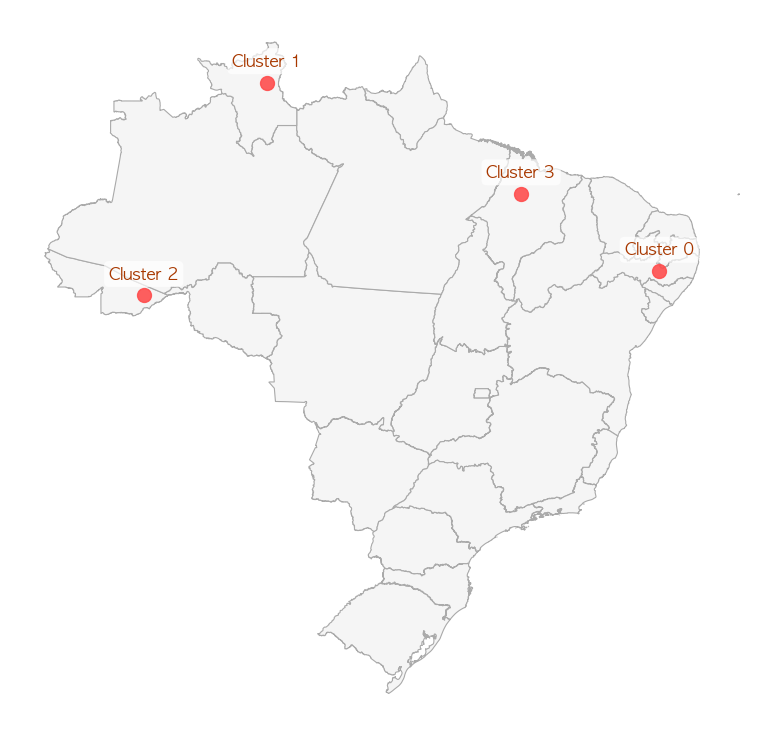

In [583]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1️⃣ 관심 있는 주만 필터링
target_states = ['RR','AL','MA','CE','PI','PA','BA','PB','AC','PE']

state_coords = (
    orders_enriched.groupby('customer_state')
    .agg(
        state_lat=('customer_lat', 'mean'),
        state_lng=('customer_lng', 'mean')
    )
    .reset_index()
)

pareto_subset = state_coords [state_coords ['customer_state'].isin(target_states)].copy()

# 2️⃣ KMeans 입력 (위도/경도)
X = pareto_subset[['state_lat','state_lng']].values

# 3️⃣ KMeans 클러스터링
k = 4  # 클러스터 수 조정 가능
kmeans = KMeans(n_clusters=k, random_state=42)
pareto_subset['cluster'] = kmeans.fit_predict(X)

# 클러스터 중심 GeoDataFrame
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['lat','lng'])
geometry = [Point(xy) for xy in zip(cluster_centers['lng'], cluster_centers['lat'])]
gdf_clusters = gpd.GeoDataFrame(cluster_centers, geometry=geometry, crs="EPSG:4326")

# 4️⃣ 지도 시각화
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf_states = gpd.read_file(geo_url)

fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_alpha(0)  # 배경 투명

# 주 경계 및 배경 색상
gdf_states.plot(ax=ax, facecolor="#f5f5f5", edgecolor="#aaaaaa", linewidth=0.8)

# 클러스터 중심 빨간 점
gdf_clusters.plot(ax=ax, color="#ff4d4d", markersize=100, alpha=0.9, edgecolor=None)

# 라벨 점 위쪽
for x, y, idx in zip(gdf_clusters.geometry.x, gdf_clusters.geometry.y, gdf_clusters.index):
    ax.text(
        x, y+0.8, f"Cluster {idx}",  # 점 위쪽으로 이동
        fontsize=12, fontweight='bold', color="#A83800", ha='center', va='bottom',
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3")
    )

# 축, 그리드 제거
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_aspect("equal")
ax.grid(False)
ax.set_axis_off()

plt.tight_layout()
# 저장할 때도 투명하게
plt.savefig("brazil_clusters.png", dpi=300, transparent=True)
plt.show()


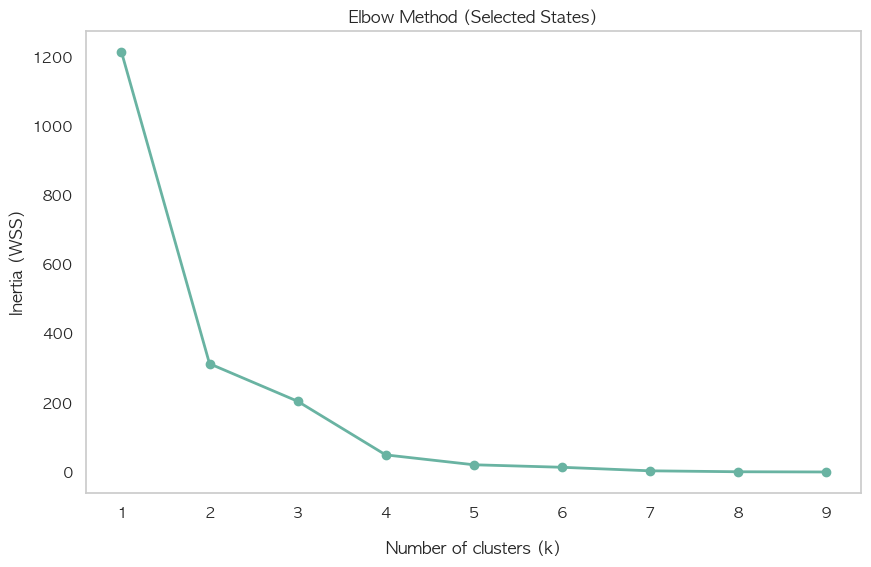

In [479]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 관심 주 필터링
target_states = ['RR','AL','MA','CE','PI','PA','BA','PB','AC','PE']
pareto_subset = pareto_candidates_coords[pareto_candidates_coords['customer_state'].isin(target_states)].copy()

# KMeans 입력 (위도/경도)
X = pareto_subset[['state_lat','state_lng']].values

# =====================
# 엘보우 메서드
# =====================
inertia = []
K_range = range(1, 10)  # 클러스터 수 후보

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# =====================
# 시각화
# =====================
plt.figure(figsize=(10,6))
plt.plot(K_range, inertia, 'o-', color="#69b3a2", linewidth=2)
plt.xlabel("Number of clusters (k)", labelpad=15)
plt.ylabel("Inertia (WSS)")
plt.title("Elbow Method (Selected States)")
plt.grid(False)

#저장
plt.savefig("Elbow Method.png", dpi=300)
plt.show()


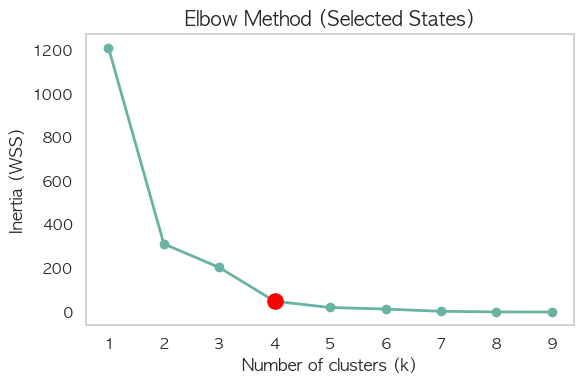

In [491]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 관심 주 필터링
target_states = ['RR','AL','MA','CE','PI','PA','BA','PB','AC','PE']
pareto_subset = pareto_candidates_coords[pareto_candidates_coords['customer_state'].isin(target_states)].copy()

# KMeans 입력 (위도/경도)
X = pareto_subset[['state_lat','state_lng']].values

# =====================
# 엘보우 메서드 계산
# =====================
inertia = []
K_range = range(1, 10)  # 클러스터 수 후보

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# =====================
# 시각화
# =====================
plt.figure(figsize=(6,4))

# 기본 라인
plt.plot(K_range, inertia, 'o-', color="#69b3a2", linewidth=2)

# 최적 k 강조 (k=4)
optimal_k = 4
plt.scatter(optimal_k, inertia[optimal_k-1], color="red", s=120, zorder=5)


# 축 라벨, 제목
plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Inertia (WSS)", fontsize=12)
plt.title("Elbow Method (Selected States)", fontsize=14)

# 그리드 제거
plt.grid(False)

plt.tight_layout()
plt.savefig("Elbow Method.png", dpi=300, bbox_inches='tight')
plt.show()


In [235]:
cluster_centers

lat        lng
0 -8.457336 -37.183323
1  2.836697 -60.675256
2 -9.908545 -68.060668
3 -3.817597 -45.457261

In [237]:
pareto_subset

customer_state  state_lat  state_lng  cluster
0              AC  -9.908545 -68.060668        2
1              AL  -9.642008 -36.038522        0
4              BA -13.026063 -39.465926        0
5              CE  -4.329944 -38.966454        0
9              MA  -3.577980 -44.707295        3
13             PA  -2.378386 -49.072875        3
14             PB  -7.088849 -35.666331        0
15             PE  -8.199816 -35.779378        0
16             PI  -5.496423 -42.591615        3
21             RR   2.836697 -60.675256        1

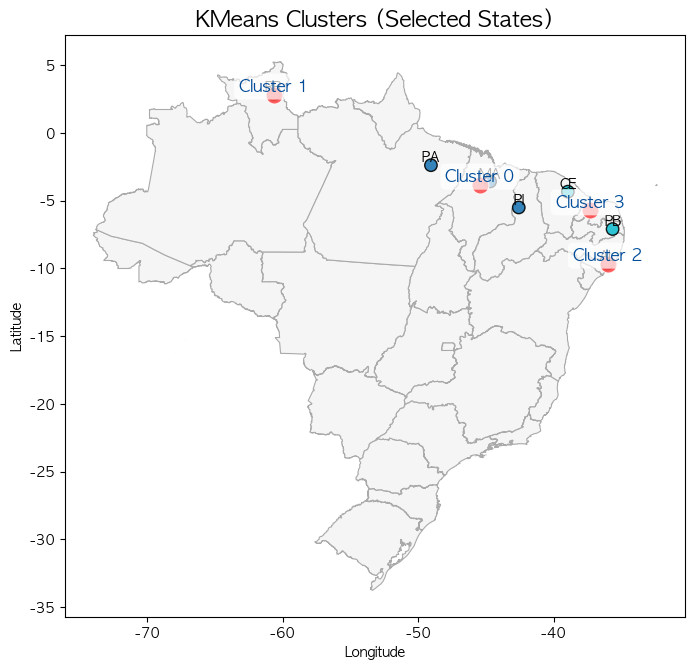

In [167]:
# =======================
# 2️⃣ GeoDataFrame 변환
# =======================
geometry_points = [Point(xy) for xy in zip(pareto_subset['state_lng'], pareto_subset['state_lat'])]
gdf_points = gpd.GeoDataFrame(pareto_subset, geometry=geometry_points, crs="EPSG:4326")

geometry_centers = [Point(xy) for xy in zip(cluster_centers['lng'], cluster_centers['lat'])]
gdf_clusters = gpd.GeoDataFrame(cluster_centers, geometry=geometry_centers, crs="EPSG:4326")

# =======================
# 3️⃣ 지도 시각화
# =======================
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf_states = gpd.read_file(geo_url)

fig, ax = plt.subplots(figsize=(8,8))
gdf_states.plot(ax=ax, facecolor="#f5f5f5", edgecolor="#aaaaaa", linewidth=0.8)

# (a) 주별 포인트를 군집별 색상으로 표시
gdf_points.plot(ax=ax, column="cluster", cmap="tab10", markersize=80, alpha=0.9, edgecolor="black")

# (b) 클러스터 중심 (빨간 원)
gdf_clusters.plot(ax=ax, color="#ff4d4d", markersize=150, alpha=0.9, edgecolor="white", linewidth=0.7)

# 라벨 표시
for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points["customer_state"]):
    ax.text(x, y, label, fontsize=10, fontweight="bold", color="black", ha="center", va="bottom")

for x, y, idx in zip(gdf_clusters.geometry.x, gdf_clusters.geometry.y, gdf_clusters.index):
    ax.text(x, y, f"Cluster {idx}", fontsize=12, fontweight='bold', color="#004c99",
            ha='center', va='bottom',
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3"))

ax.set_title("KMeans Clusters (Selected States)", fontsize=16, fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")

plt.show()

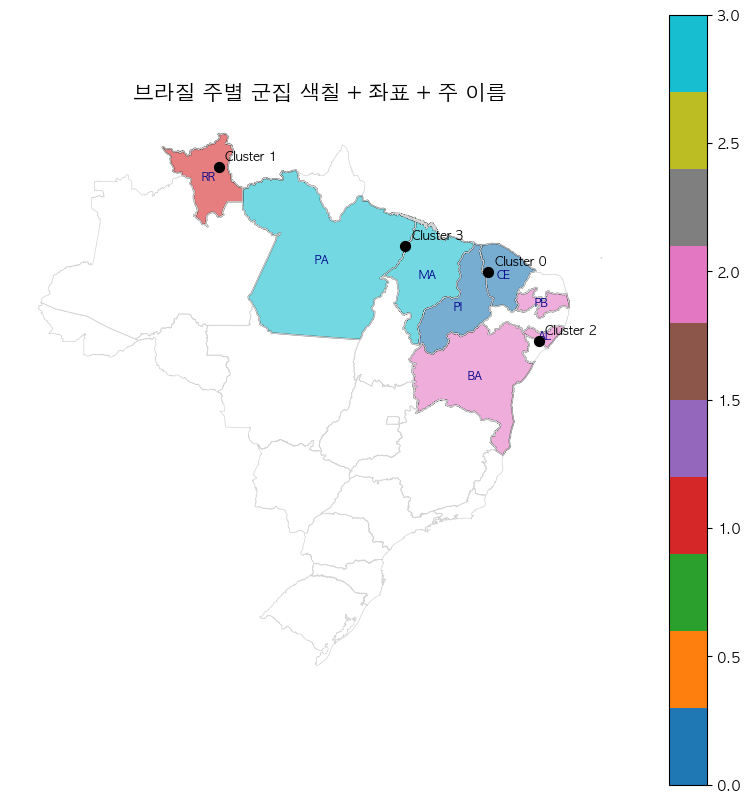

In [183]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1️⃣ 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 2️⃣ 군집 매핑
cluster_map = {
    "CE": 0, "PI": 0,   # Cluster 0
    "RR": 1,            # Cluster 1
    "AL": 2, "BA": 2, "PB": 2,  # Cluster 2
    "MA": 3, "PA": 3    # Cluster 3
}
brazil["cluster"] = brazil["sigla"].map(cluster_map)

# 3️⃣ 좌표 데이터프레임
coords = {
    0: (-4.913183, -40.779034),
    1: (2.836697, -60.675256),
    2: (-9.918973, -37.056927),
    3: (-2.978183, -46.890085)
}

# 4️⃣ 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# 전체 브라질 경계선
brazil.boundary.plot(ax=ax, color="lightgray", linewidth=0.5)

# 군집 색칠
brazil.dropna(subset=["cluster"]).plot(
    column="cluster", 
    ax=ax, 
    cmap="tab10",   # 색상 팔레트
    legend=True,
    edgecolor="black",
    alpha=0.6
)

# 좌표 찍기
for idx, (lat, lon) in coords.items():
    ax.scatter(lon, lat, color="black", marker="o", s=50, zorder=5)
    ax.text(lon+0.5, lat+0.5, f"Cluster {idx}", fontsize=9, color="black")

# 주 이름 표시 (중심점 기준)
for _, row in brazil.dropna(subset=["cluster"]).iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, 
        row["sigla"], 
        ha="center", va="center", fontsize=8, fontweight="bold", color="darkblue"
    )

plt.title("브라질 주별 군집 색칠 + 좌표 + 주 이름", fontsize=15)
plt.axis("off")
plt.show()


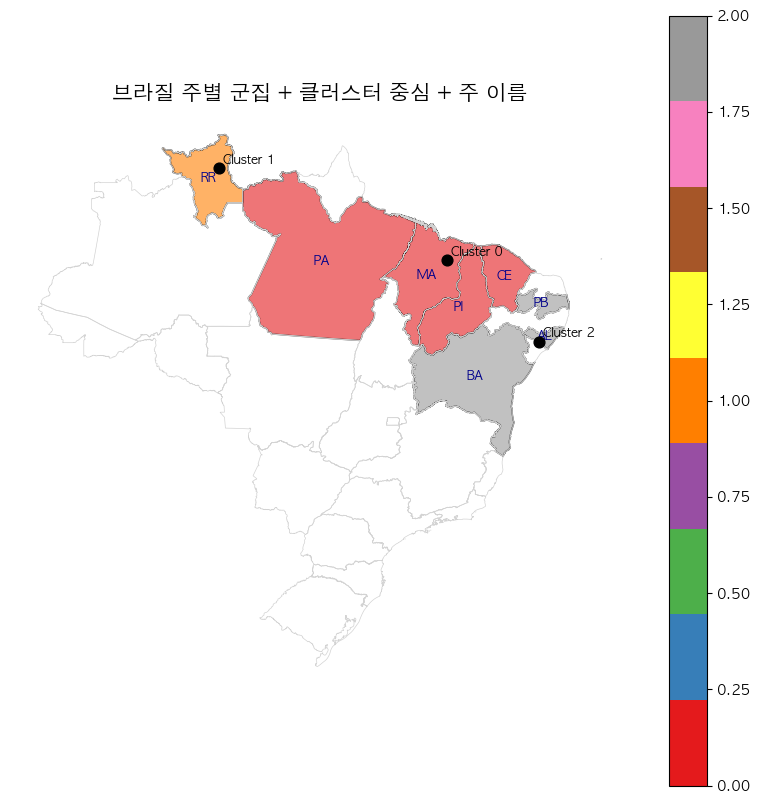

In [193]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1️⃣ 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 2️⃣ 군집 매핑 (pareto_subset 기준)
cluster_map = {
    "AL": 2,
    "BA": 2,
    "CE": 0,
    "MA": 0,
    "PA": 0,
    "PB": 2,
    "PI": 0,
    "RR": 1
}
brazil["cluster"] = brazil["sigla"].map(cluster_map)

# 3️⃣ 클러스터 중심 좌표
cluster_coords = {
    0: (-3.945683, -43.834560),
    1: (2.836697, -60.675256),
    2: (-9.918973, -37.056927)
}

# 4️⃣ 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# 전체 브라질 회색 경계
brazil.boundary.plot(ax=ax, color="lightgray", linewidth=0.5)

# 군집 색칠
brazil.dropna(subset=["cluster"]).plot(
    column="cluster",
    ax=ax,
    cmap="Set1",    # 색상 팔레트
    legend=True,
    edgecolor="black",
    alpha=0.6
)

# 클러스터 중심 표시
for idx, (lat, lon) in cluster_coords.items():
    ax.scatter(lon, lat, color="black", marker="o", s=60, zorder=5)
    ax.text(lon + 0.3, lat + 0.3, f"Cluster {idx}", fontsize=9, color="black")

# 주 이름 표시 (주 영역 중심)
for _, row in brazil.dropna(subset=["cluster"]).iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row["sigla"],
        ha="center", va="center",
        fontsize=9, fontweight="bold", color="darkblue"
    )

plt.title("브라질 주별 군집 + 클러스터 중심 + 주 이름", fontsize=15)
plt.axis("off")
plt.show()


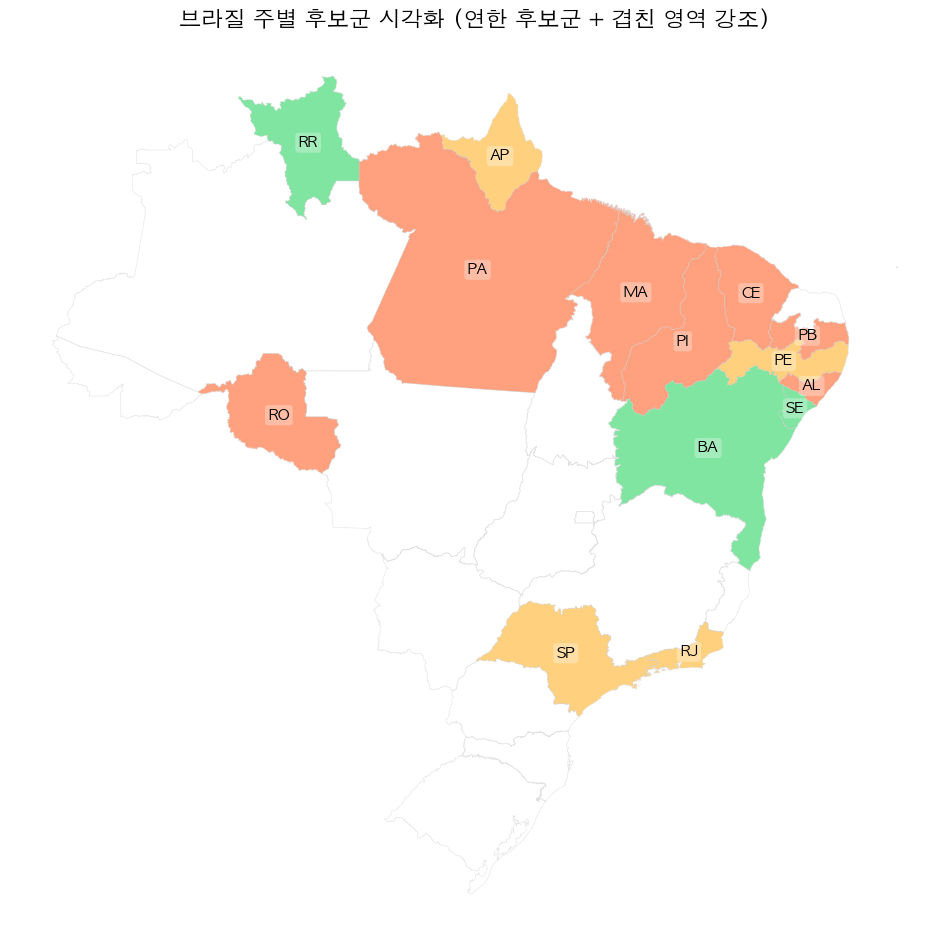

In [219]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 후보군 설정
pareto_candidates = ['AL','AP','CE','MA','PA','PB','PE','PI','RJ','RO','SP']
customer_candidates = ['RR','AL','MA','SE','CE','PI','PA','RO','BA','PB']

# 후보군 플래그 컬럼 생성
brazil['pareto'] = brazil['sigla'].apply(lambda x: x in pareto_candidates)
brazil['customer'] = brazil['sigla'].apply(lambda x: x in customer_candidates)

# 색상 결정 함수
def assign_color(row):
    if row['pareto'] and row['customer']:
        return '#FF4500'  # 겹친 영역: 진한 빨강-오렌지
    elif row['pareto']:
        return '#FFA500'  # 파레토 후보군: 연한 오렌지
    elif row['customer']:
        return '#00CC44'  # 고객 후보군: 연한 녹색
    else:
        return 'white'

brazil['color'] = brazil.apply(assign_color, axis=1)

# 시각화
fig, ax = plt.subplots(figsize=(12,12))

# 전체 지도
brazil.plot(
    ax=ax,
    color=brazil['color'],
    edgecolor='lightgray',
    linewidth=0.5,
    alpha=0.5  # 파레토, 고객 후보군 투명도
)

# 후보군 이름 표시
for _, row in brazil.iterrows():
    if row['pareto'] or row['customer']:
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, row['sigla'],
            ha='center', va='center', fontsize=11, fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.title("브라질 주별 후보군 시각화 (연한 후보군 + 겹친 영역 강조)", fontsize=16, fontweight='bold')
plt.axis('off')
fig.patch.set_alpha(0)

plt.show()


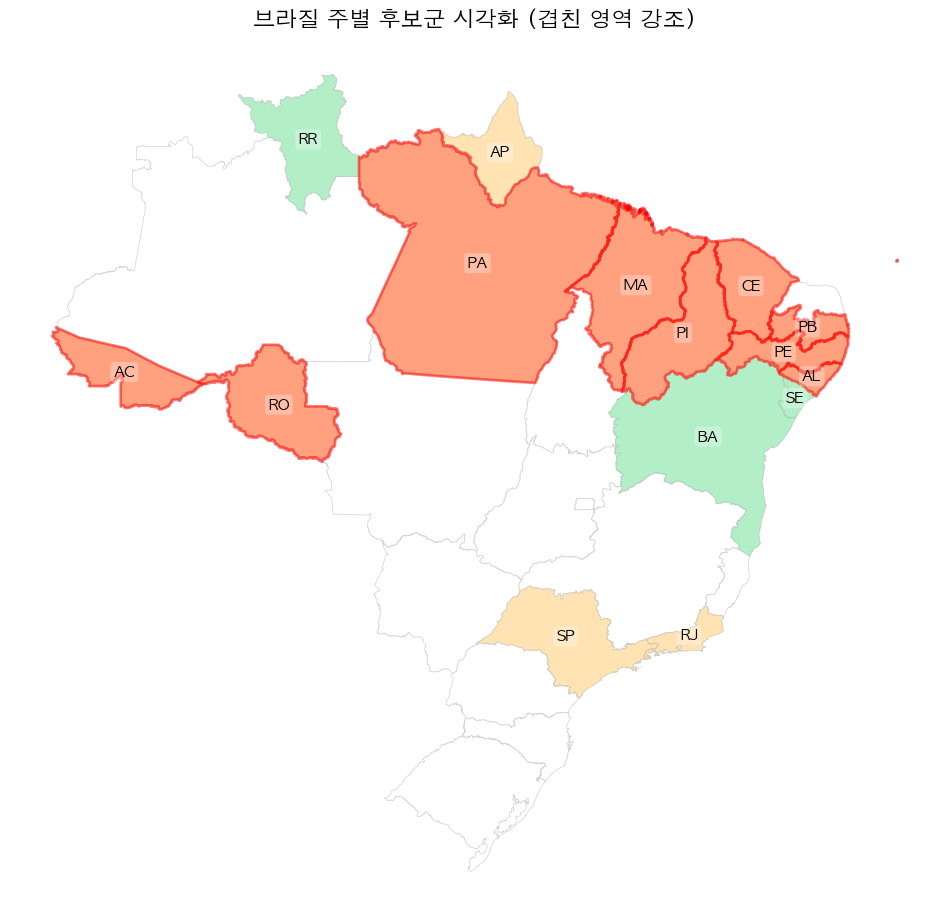

In [241]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 후보군 설정
pareto_candidates = ['AL','AP','CE','MA','PA','PB','PE','PI','RJ','RO','SP','AC','PE']
customer_candidates = ['RR','AL','MA','SE','CE','PI','PA','RO','BA','PB','AC','PE']

# 후보군 플래그 컬럼 생성
brazil['pareto'] = brazil['sigla'].apply(lambda x: x in pareto_candidates)
brazil['customer'] = brazil['sigla'].apply(lambda x: x in customer_candidates)

# 시각화
fig, ax = plt.subplots(figsize=(12,12))

# 배경: 전체 지도
brazil.plot(ax=ax, color='white', edgecolor='lightgray', linewidth=0.5)

# 파레토 후보군 (연한 오렌지, 투명도)
brazil[brazil['pareto'] & ~brazil['customer']].plot(
    ax=ax, color='#FFA500', alpha=0.3, edgecolor='lightgray', linewidth=0.8
)

# 고객 후보군 (연한 녹색, 투명도)
brazil[brazil['customer'] & ~brazil['pareto']].plot(
    ax=ax, color='#00CC44', alpha=0.3, edgecolor='lightgray', linewidth=0.8
)

# 겹친 영역 강조 (진한 오렌지, 테두리 굵게)
brazil[brazil['pareto'] & brazil['customer']].plot(
    ax=ax, color='#FF4500', alpha=0.5, edgecolor='red', linewidth=2
)

# 후보군 이름 표시
for _, row in brazil.iterrows():
    if row['pareto'] or row['customer']:
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, row['sigla'],
            ha='center', va='center', fontsize=11, fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.title("브라질 주별 후보군 시각화 (겹친 영역 강조)", fontsize=16, fontweight='bold')
plt.axis('off')
fig.patch.set_alpha(0)
plt.show()


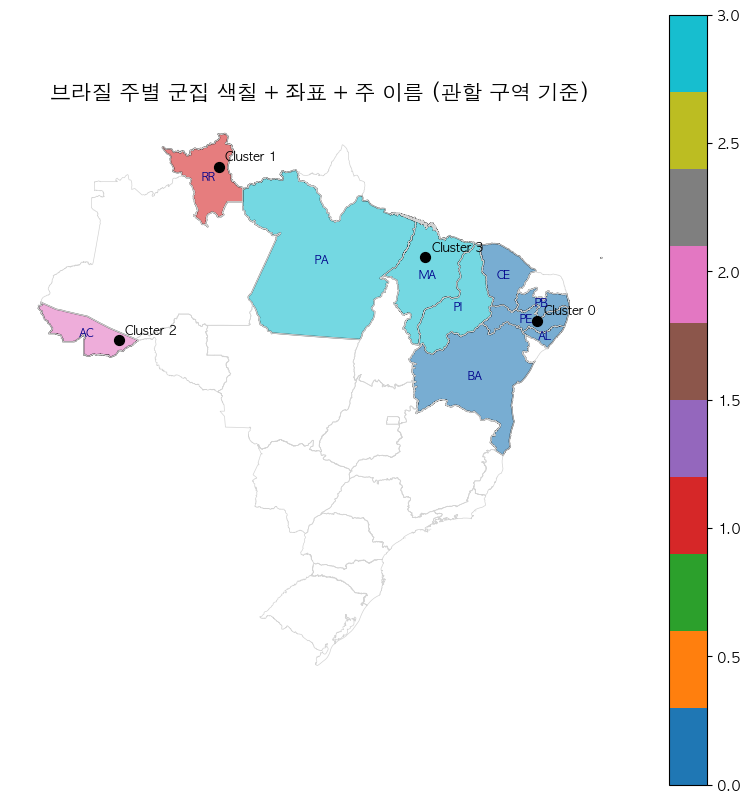

In [239]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1️⃣ 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 2️⃣ 군집 매핑 (관할 구역 기준)
cluster_map = {
    "AL": 0, "BA": 0, "CE": 0, "PB": 0, "PE": 0,  # Cluster 0
    "RR": 1,                                     # Cluster 1
    "AC": 2,                                     # Cluster 2
    "MA": 3, "PA": 3, "PI": 3                    # Cluster 3
}
brazil["cluster"] = brazil["sigla"].map(cluster_map)

# 3️⃣ 좌표 데이터프레임
coords = {
    0: (-8.457336, -37.183323),  # Cluster 0
    1: (2.836697, -60.675256),   # Cluster 1
    2: (-9.908545, -68.060668),  # Cluster 2
    3: (-3.817597, -45.457261)   # Cluster 3
}

# 4️⃣ 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# 전체 브라질 경계선
brazil.boundary.plot(ax=ax, color="lightgray", linewidth=0.5)

# 군집 색칠
brazil.dropna(subset=["cluster"]).plot(
    column="cluster", 
    ax=ax, 
    cmap="tab10",   # 색상 팔레트
    legend=True,
    edgecolor="black",
    alpha=0.6
)

# 좌표 찍기 및 라벨
for idx, (lat, lon) in coords.items():
    ax.scatter(lon, lat, color="black", marker="o", s=50, zorder=5)
    ax.text(lon+0.5, lat+0.5, f"Cluster {idx}", fontsize=9, color="black")

# 주 이름 표시 (중심점 기준)
for _, row in brazil.dropna(subset=["cluster"]).iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, 
        row["sigla"], 
        ha="center", va="center", fontsize=8, fontweight="bold", color="darkblue"
    )

plt.title("브라질 주별 군집 색칠 + 좌표 + 주 이름 (관할 구역 기준)", fontsize=15)
plt.axis("off")
plt.show()


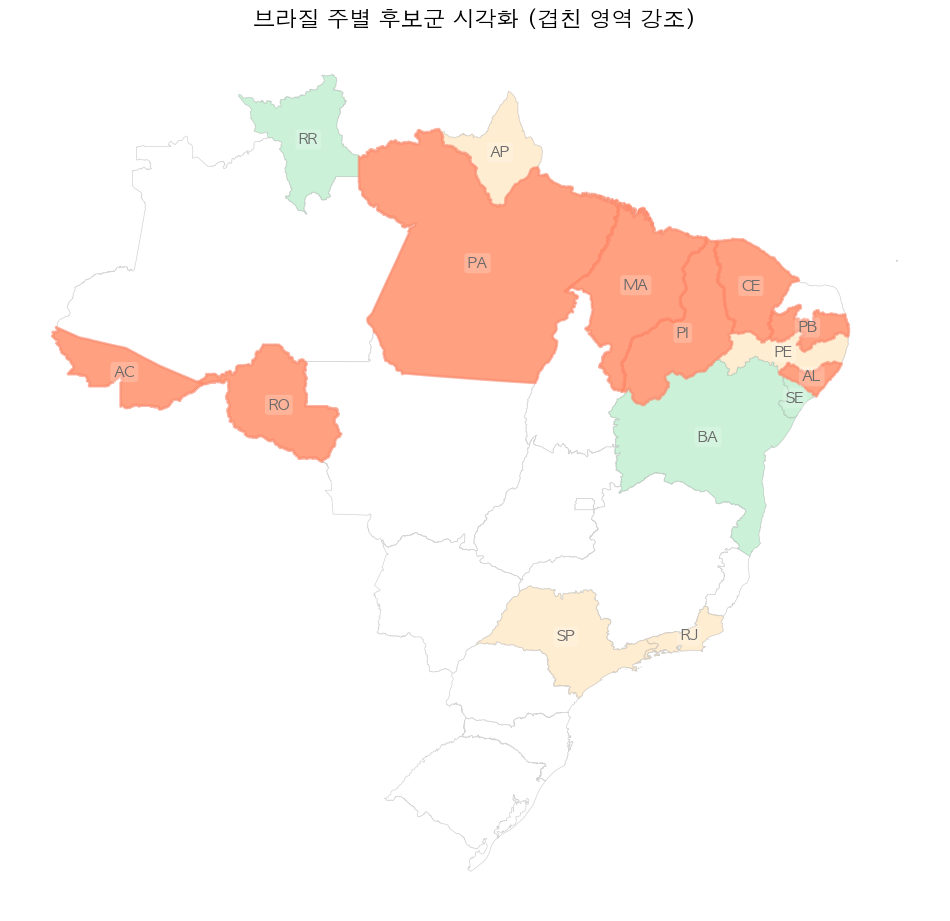

In [245]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 후보군 설정
pareto_candidates = ['AL','AP','CE','MA','PA','PB','PE','PI','RJ','RO','SP','AC']
customer_candidates = ['RR','AL','MA','SE','CE','PI','PA','RO','BA','PB','AC']

# 후보군 플래그 컬럼 생성
brazil['pareto'] = brazil['sigla'].apply(lambda x: x in pareto_candidates)
brazil['customer'] = brazil['sigla'].apply(lambda x: x in customer_candidates)

# 시각화
fig, ax = plt.subplots(figsize=(12,12))

# 전체 배경
brazil.plot(ax=ax, color='white', edgecolor='lightgray', linewidth=0.5)

# 파레토 후보군
brazil[brazil['pareto'] & ~brazil['customer']].plot(
    ax=ax, color='#FFB84D', alpha=0.25, edgecolor='lightgray', linewidth=0.7
)

# 고객 후보군
brazil[brazil['customer'] & ~brazil['pareto']].plot(
    ax=ax, color='#33CC66', alpha=0.25, edgecolor='lightgray', linewidth=0.7
)

# 겹친 영역 강조 (조금 더 진하게)
brazil[brazil['pareto'] & brazil['customer']].plot(
    ax=ax, color='#FF6F3C', alpha=0.65, edgecolor='#FF8D70', linewidth=2
)

# 후보군 이름 표시
for _, row in brazil.iterrows():
    if row['pareto'] or row['customer']:
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, row['sigla'],
            ha='center', va='center', fontsize=11, fontweight='bold',
            color='dimgray',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.title("브라질 주별 후보군 시각화 (겹친 영역 강조)", fontsize=16, fontweight='bold')
plt.axis('off')
fig.patch.set_alpha(0)
plt.show()


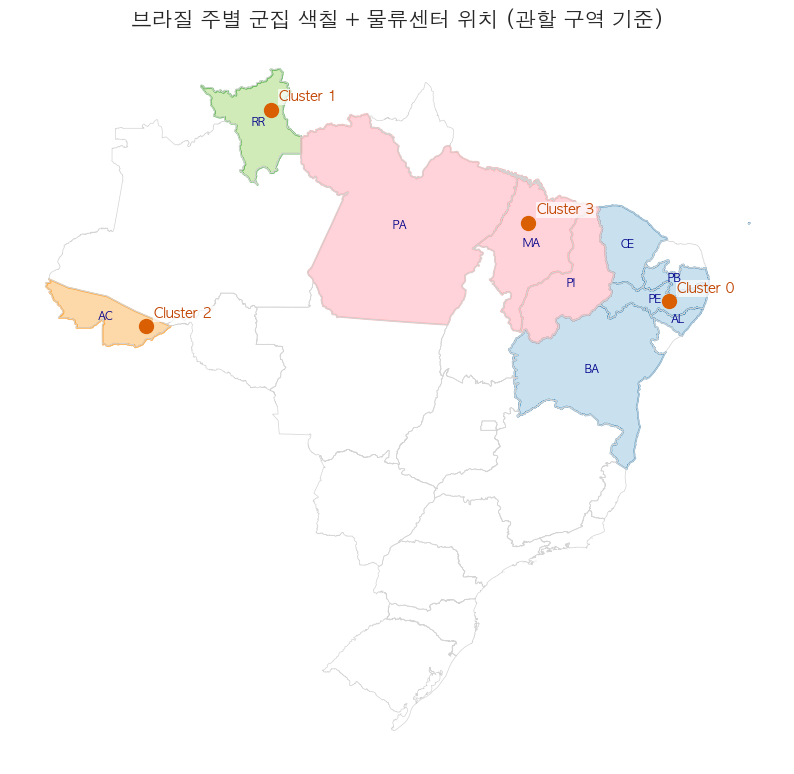

In [515]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1️⃣ 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 2️⃣ 군집 매핑 (관할 구역 기준)
cluster_map = {
    "AL": 0, "BA": 0, "CE": 0, "PB": 0, "PE": 0,  # Cluster 0
    "RR": 1,                                     # Cluster 1
    "AC": 2,                                     # Cluster 2
    "MA": 3, "PA": 3, "PI": 3                    # Cluster 3
}
brazil["cluster"] = brazil["sigla"].map(cluster_map)

# 3️⃣ 물류센터 좌표
coords = {
    0: (-8.457336, -37.183323),  # Cluster 0
    1: (2.836697, -60.675256),   # Cluster 1
    2: (-9.908545, -68.060668),  # Cluster 2
    3: (-3.817597, -45.457261)   # Cluster 3
}

# 4️⃣ 군집별 색상 직접 지정 (파스텔톤)
cluster_colors = {
    0: "#A6CEE3",  # 연한 파랑
    1: "#B2DF8A",  # 연한 초록
    2: "#FDBF6F",  # 연한 주황
    3: "#FFB6C1"   # 연한 분홍
}

# 5️⃣ 군집별 테두리 색상 (원래 색보다 진하게)
border_colors = {
    0: "#1F78B4",  # 진한 파랑
    1: "#33A02C",  # 진한 초록
    2: "#FF8C00",  # 진한 오렌지
    3: "#FB9A99"   # 진한 분홍
}

# 6️⃣ 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# 브라질 경계선
brazil.boundary.plot(ax=ax, color="lightgray", linewidth=0.5)

# 군집 색칠 + 테두리 강조
for cluster_id, color in cluster_colors.items():
    brazil[brazil["cluster"] == cluster_id].plot(
        ax=ax,
        color=color,
        edgecolor=border_colors[cluster_id],
        linewidth=1.2,
        alpha=0.6
    )

# 물류센터 위치
for idx, (lat, lon) in coords.items():
    ax.scatter(
        lon, lat,
        color="#D95F02",  # 진한 오렌지
        s=100,            # 점 크기
        zorder=5
    )
    # Cluster 라벨: 진한 색상
    ax.text(
        lon+0.5, lat+0.5, f"Cluster {idx}",
        fontsize=10, fontweight="bold", color= "#C14400",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1)
    )

# 주 이름 표시 (중심점 기준)
for _, row in brazil.dropna(subset=["cluster"]).iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row["sigla"],
        ha="center", va="center", fontsize=8,
        fontweight="bold", color="darkblue"
    )

plt.title("브라질 주별 군집 색칠 + 물류센터 위치 (관할 구역 기준)", fontsize=15)
plt.axis("off")
plt.show()


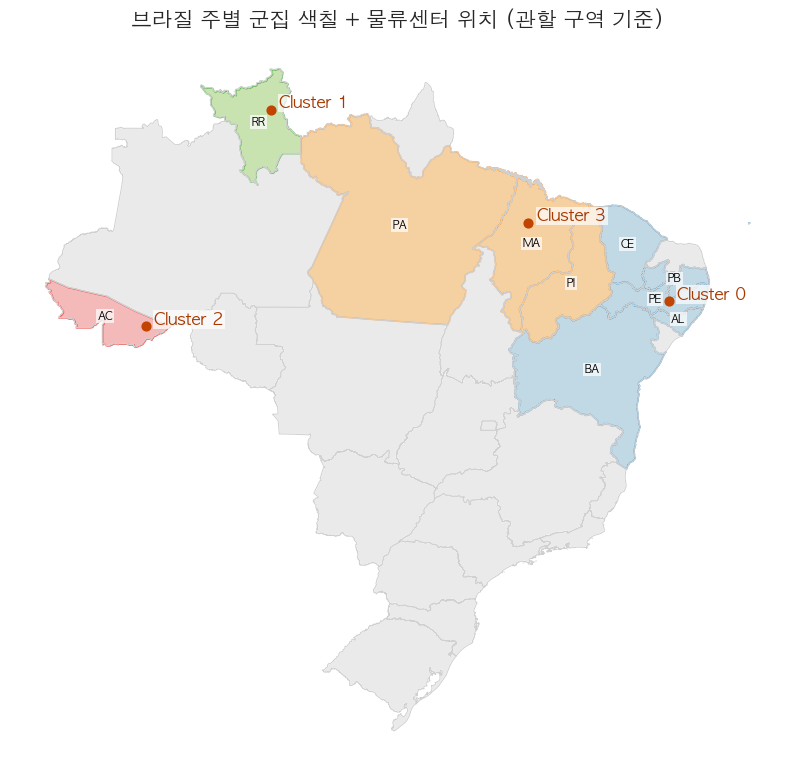

In [597]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1️⃣ 브라질 주 경계 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 2️⃣ 군집 매핑 (관할 구역 기준)
cluster_map = {
    "AL": 0, "BA": 0, "CE": 0, "PB": 0, "PE": 0,  # Cluster 0
    "RR": 1,                                     # Cluster 1
    "AC": 2,                                     # Cluster 2
    "MA": 3, "PA": 3, "PI": 3                    # Cluster 3
}
brazil["cluster"] = brazil["sigla"].map(cluster_map)

# 3️⃣ 좌표 데이터프레임 (물류센터 위치)
coords = {
    0: (-8.457336, -37.183323),  # Cluster 0
    1: (2.836697, -60.675256),   # Cluster 1
    2: (-9.908545, -68.060668),  # Cluster 2
    3: (-3.817597, -45.457261)   # Cluster 3
}

# 4️⃣ 클러스터 색상 지정 (파스텔톤)
cluster_colors = {
    0: "#A6CEE3",  # 연한 파랑
    1: "#B2DF8A",  # 연한 초록
    2: "#FB9A99",  # 연한 빨강
    3: "#FDBF6F"   # 연한 오렌지
}

# 5️⃣ 테두리 색상 (군집 색보다 약간 진하게)
cluster_edge_colors = {
    0: "#1F78B4",
    1: "#33A02C",
    2: "#E31A1C",
    3: "#FF7F00"
}

# 6️⃣ 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# 전체 브라질 경계선 / 전체 브라질 영역을 연한 회색으로 채움
brazil.boundary.plot(ax=ax, color="#d0d0d0", linewidth=0.7)
brazil.plot(ax=ax, color="#eaeaea")  # 연한 회색


# 군집 색칠 + 테두리
for cluster_id, color in cluster_colors.items():
    brazil[brazil["cluster"]==cluster_id].plot(
        ax=ax,
        color=color,
        edgecolor=cluster_edge_colors[cluster_id],
        linewidth=1,
        alpha=0.6
    )

# 물류센터 좌표
for idx, (lat, lon) in coords.items():
    ax.scatter(lon, lat, color="#C14400", marker="o", s=40, zorder=5)
    # Cluster 라벨: 진한 색상
    ax.text(
        lon+0.5, lat+0.1, f"Cluster {idx}",
        fontsize=12, fontweight=1000, color= "#A83800",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1)
    )


# 주 이름 표시 (중심점 기준, 배경 흰색)
for _, row in brazil.dropna(subset=["cluster"]).iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row["sigla"],
        ha="center", va="center",
        fontsize=8, fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1)
    )

plt.title("브라질 주별 군집 색칠 + 물류센터 위치 (관할 구역 기준)", fontsize=15)
plt.axis("off")

plt.savefig("물류센터 위치.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()


### 물류센터별 효율성 예측

In [255]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95547 entries, 0 to 99439
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      95547 non-null  object 
 1   customer_lat  95547 non-null  float64
 2   customer_lng  95547 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.9+ MB


In [339]:
# -----------------------
# 배송기간 계산
# -----------------------
orders['delivery_days'] = (orders['order_delivered_date'] - orders['order_approved_date']).dt.days

# -----------------------
# 상품 단위로 orders와 합치기
# -----------------------
df = items.merge(
    orders[['order_id', 'customer_lat', 'customer_lng', 'customer_state', 'delivery_days']],
    on='order_id',
    how='left'
)

# -----------------------
# 관할 구역 매핑 (판매자-관할은 그대로)
# -----------------------
center_data = [
    {'lat': -8.457336, 'lng': -37.183323, 'states': ['AL','BA','CE','PB','PE']},
    {'lat': 2.836697, 'lng': -60.675256, 'states': ['RR']},
    {'lat': -9.908545, 'lng': -68.060668, 'states': ['AC']},
    {'lat': -3.817597, 'lng': -45.457261, 'states': ['MA','PA','PI']}
]

state_to_group = {}
for center in center_data:
    states_str = ",".join(center['states'])
    for st in center['states']:
        state_to_group[st] = states_str

df['center_states'] = df['customer_state'].map(state_to_group)

# -----------------------
# 관할 없는 주문 제거
# -----------------------
df = df.dropna(subset=['center_states'])

# -----------------------
# 거리 계산 함수 (Haversine)
# -----------------------
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

# -----------------------
# 판매자-구매자 거리 계산
# -----------------------
df['distance_km'] = df.apply(lambda row: haversine(
    row['seller_lat'], row['seller_lng'],
    row['customer_lat'], row['customer_lng']
), axis=1)

# -----------------------
# 관할 구역별 요약
# -----------------------
seller_summary = df.groupby('center_states', sort=False).agg(
    avg_distance_km=('distance_km','mean'),
    avg_delivery_days=('delivery_days','mean'),
    n_orders=('order_id','count')
).reset_index()

# -----------------------
# center_data 순서대로 정렬
# -----------------------
center_order = [",".join(c['states']) for c in center_data]
seller_summary['center_order'] = seller_summary['center_states'].apply(lambda x: center_order.index(x))
seller_summary = seller_summary.sort_values('center_order').drop(columns='center_order').reset_index(drop=True)

print(seller_summary)

    center_states  avg_distance_km  avg_delivery_days  n_orders
0  AL,BA,CE,PB,PE      1719.328457          19.042859      7793
1              RR      3246.918055          27.673913        46
2              AC      2644.435479          20.144444        90
3        MA,PA,PI      2155.173179          21.214134      2349


   center_lat  center_lng   center_states  avg_distance_km
0   -8.457336  -37.183323  AL,BA,CE,PB,PE       449.321742
1    2.836697  -60.675256              RR         6.009226
2   -9.908545  -68.060668              AC        53.967996
3   -3.817597  -45.457261        MA,PA,PI       380.640871
    center_states  avg_distance_km  avg_delivery_days  n_orders
0  AL,BA,CE,PB,PE      1719.328457          19.042859      7793
1              RR      3246.918055          27.673913        46
2              AC      2644.435479          20.144444        90
3        MA,PA,PI      2155.173179          21.214134      2349


In [375]:
## 물류센터 위치를 기준으로 한 관할 구역별 평균 거리·배송기간


# -----------------------
# 배송기간 계산
# -----------------------
orders['delivery_days'] = (orders['order_delivered_date'] - orders['order_approved_date']).dt.days

# -----------------------
# 상품 단위로 orders와 합치기
# -----------------------
df = items.merge(
    orders[['order_id', 'customer_lat', 'customer_lng', 'customer_state', 'delivery_days']],
    on='order_id',
    how='left'
)

# -----------------------
# 센터 위치 및 관할 구역 정의
# -----------------------
center_data = [
    {'lat': -8.457336, 'lng': -37.183323, 'states': ['AL','BA','CE','PB','PE']},
    {'lat': 2.836697, 'lng': -60.675256, 'states': ['RR']},
    {'lat': -9.908545, 'lng': -68.060668, 'states': ['AC']},
    {'lat': -3.817597, 'lng': -45.457261, 'states': ['MA','PA','PI']}
]

# state → 센터 좌표 및 관할 구역 매핑
state_to_center_lat = {}
state_to_center_lng = {}
state_to_center_group = {}
for center in center_data:
    states_str = ",".join(center['states'])
    for st in center['states']:
        state_to_center_lat[st] = center['lat']
        state_to_center_lng[st] = center['lng']
        state_to_center_group[st] = states_str

df['center_lat'] = df['customer_state'].map(state_to_center_lat)
df['center_lng'] = df['customer_state'].map(state_to_center_lng)
df['center_states'] = df[import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    'center_id': [0, 1, 2, 3],
    'center_states': ['AL,BA,CE,PB,PE', 'RR', 'AC', 'MA,PA,PI'],
    'distance_reduction_pct': [73.87, 99.81, 97.96, 82.34]
}

df = pd.DataFrame(data)

# Treemap 시각화
fig = px.treemap(
    df,
    path=['center_id', 'center_states'],  # hierarchy
    values='distance_reduction_pct',     # 박스 크기
    color='distance_reduction_pct',      # 색상
    color_continuous_scale='Blues',
    title='물류센터별 평균 거리 감소율'
)

fig.show()

# 관할 없는 주문 제거
df = df.dropna(subset=['center_lat','center_lng'])

# -----------------------
# 거리 계산 함수 (Haversine)
# -----------------------
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # km
    return c * r

# -----------------------
# 기존 판매자 → 고객 거리
df['seller_to_customer_km'] = df.apply(lambda row: haversine(
    row['seller_lat'], row['seller_lng'],
    row['customer_lat'], row['customer_lng']
), axis=1)

# 물류센터 → 고객 거리
df['center_to_customer_km'] = df.apply(lambda row: haversine(
    row['center_lat'], row['center_lng'],
    row['customer_lat'], row['customer_lng']
), axis=1)

# -----------------------
# 예상 배송기간 계산 (거리 비례)
df['expected_delivery_days'] = df['delivery_days'] * (df['center_to_customer_km'] / df['seller_to_customer_km'])

# -----------------------
# 센터별 요약
center_summary = df.groupby(['center_lat','center_lng','center_states'], sort=False).agg(
    avg_distance_km=('center_to_customer_km','mean'),
    expected_delivery_days=('expected_delivery_days','mean'),
    n_orders=('order_id','count')
).reset_index()

# center_data 순서대로 정렬
center_order = [ (c['lat'], c['lng']) for c in center_data ]
center_summary['center_order'] = center_summary.apply(lambda x: center_order.index((x['center_lat'], x['center_lng'])), axis=1)
center_summary = center_summary.sort_values('center_order').drop(columns='center_order').reset_index(drop=True)

print(center_summary)


SyntaxError: invalid syntax (1435770934.py, line 41)

In [353]:
print(center_summary)  ## 거리는 확실히 줄어듦 !!
print(seller_summary)

   center_lat  center_lng   center_states  avg_distance_km  \
0   -8.457336  -37.183323  AL,BA,CE,PB,PE       449.321742   
1    2.836697  -60.675256              RR         6.009226   
2   -9.908545  -68.060668              AC        53.967996   
3   -3.817597  -45.457261        MA,PA,PI       380.640871   

   expected_delivery_days  n_orders  
0                8.133087      7793  
1                0.048520        46  
2                0.410137        90  
3                5.360293      2349  
    center_states  avg_distance_km  avg_delivery_days  n_orders
0  AL,BA,CE,PB,PE      1719.328457          19.042859      7793
1              RR      3246.918055          27.673913        46
2              AC      2644.435479          20.144444        90
3        MA,PA,PI      2155.173179          21.214134      2349


In [357]:
efficiency = seller_summary.copy()
efficiency = efficiency.merge(center_summary[['center_states','avg_distance_km','expected_delivery_days']], 
                              on='center_states', 
                              how='left', 
                              suffixes=('_seller','_center'))

efficiency['distance_reduction_pct'] = (efficiency['avg_distance_km_seller'] - efficiency['avg_distance_km_center']) / efficiency['avg_distance_km_seller'] * 100
efficiency['delivery_time_reduction_pct'] = (efficiency['avg_delivery_days'] - efficiency['expected_delivery_days']) / efficiency['avg_delivery_days'] * 100

print(efficiency[['center_states','distance_reduction_pct','delivery_time_reduction_pct']])


    center_states  distance_reduction_pct  delivery_time_reduction_pct
0  AL,BA,CE,PB,PE               73.866440                    57.290618
1              RR               99.814925                    99.824672
2              AC               97.959187                    97.964019
3        MA,PA,PI               82.338270                    74.732445


In [361]:
# 실제 판매자 → 고객 거리 계산
# -----------------------
df_target['seller_to_customer_km'] = df_target.apply(lambda row: haversine(
    row['seller_lat'], row['seller_lng'],
    row['customer_lat'], row['customer_lng']
), axis=1)

# -----------------------
# 1km당 실제 배송기간 계산
# -----------------------
df_target['days_per_km'] = df_target['delivery_days'] / df_target['seller_to_customer_km']

# -----------------------
# 지역별 평균 1km당 배송기간
# -----------------------
km_per_day_summary = df_target.groupby('customer_state').agg(
    avg_days_per_km=('days_per_km','mean'),
    n_orders=('order_id','count')
).reset_index()

print(km_per_day_summary)

  customer_state  avg_days_per_km  n_orders
0             AC         0.007635        90
1             AL         0.014965       427
2             BA         0.021651      3647
3             CE         0.012402      1409
4             MA         0.028995       794
5             PA         0.010456      1039
6             PB         0.014945       575
7             PE         0.013243      1735
8             PI         0.010396       516
9             RR         0.008517        46


In [363]:
# -----------------------
# center_to_customer_km 이미 df_target에 있어야 함
# 만약 없다면 계산
df_target['center_to_customer_km'] = df_target.apply(lambda row: haversine(
    row['center_lat'], row['center_lng'],
    row['customer_lat'], row['customer_lng']
), axis=1)

# -----------------------
# customer_state별 km당 평균 배송기간 merge
df_target = df_target.merge(
    km_per_day_summary[['customer_state','avg_days_per_km']],
    left_on='customer_state',
    right_on='customer_state',
    how='left'
)

# -----------------------
# 예상 배송기간 계산
df_target['expected_delivery_days_center'] = df_target['center_to_customer_km'] * df_target['avg_days_per_km']

# -----------------------
# 센터별 요약
expected_summary = df_target.groupby(['center_lat','center_lng','center_states'], sort=False).agg(
    avg_distance_km=('center_to_customer_km','mean'),
    expected_delivery_days=('expected_delivery_days_center','mean'),
    n_orders=('order_id','count')
).reset_index()

# center_data 순서대로 정렬
center_order = [ (c['lat'], c['lng']) for c in center_data ]
expected_summary['center_order'] = expected_summary.apply(lambda x: center_order.index((x['center_lat'], x['center_lng'])), axis=1)
expected_summary = expected_summary.sort_values('center_order').drop(columns='center_order').reset_index(drop=True)

print(expected_summary)


   center_lat  center_lng   center_states  avg_distance_km  \
0   -8.457336  -37.183323  AL,BA,CE,PB,PE       449.321742   
1    2.836697  -60.675256              RR         6.009226   
2   -9.908545  -68.060668              AC        53.967996   
3   -3.817597  -45.457261        MA,PA,PI       380.640871   

   expected_delivery_days  n_orders  
0                8.250538      7793  
1                0.051180        46  
2                0.412059        90  
3                5.290426      2349  


In [365]:
expected_summary ## 물류센터 -> 관할 지역 구매자

center_lat  center_lng   center_states  avg_distance_km  \
0   -8.457336  -37.183323  AL,BA,CE,PB,PE       449.321742   
1    2.836697  -60.675256              RR         6.009226   
2   -9.908545  -68.060668              AC        53.967996   
3   -3.817597  -45.457261        MA,PA,PI       380.640871   

   expected_delivery_days  n_orders  
0                8.250538      7793  
1                0.051180        46  
2                0.412059        90  
3                5.290426      2349

In [367]:
seller_summary ## 판매자 -> 관할 지역 구매자

center_states  avg_distance_km  avg_delivery_days  n_orders
0  AL,BA,CE,PB,PE      1719.328457          19.042859      7793
1              RR      3246.918055          27.673913        46
2              AC      2644.435479          20.144444        90
3        MA,PA,PI      2155.173179          21.214134      2349

In [371]:
# 두 summary 합치기
compare_df = expected_summary.merge(
    seller_summary[['center_states','avg_distance_km']],
    on='center_states',
    how='left',
    suffixes=('_center','_seller')
)

# 거리 감소율 계산
compare_df['distance_reduction_pct'] = (1 - compare_df['avg_distance_km_center'] / compare_df['avg_distance_km_seller']) * 100

# 필요한 컬럼만 선택
compare_df = compare_df[['center_states','avg_distance_km_seller','avg_distance_km_center','distance_reduction_pct']]

print(compare_df)


    center_states  avg_distance_km_seller  avg_distance_km_center  \
0  AL,BA,CE,PB,PE             1719.328457              449.321742   
1              RR             3246.918055                6.009226   
2              AC             2644.435479               53.967996   
3        MA,PA,PI             2155.173179              380.640871   

   distance_reduction_pct  
0               73.866440  
1               99.814925  
2               97.959187  
3               82.338270  


<Figure size 1000x600 with 0 Axes>

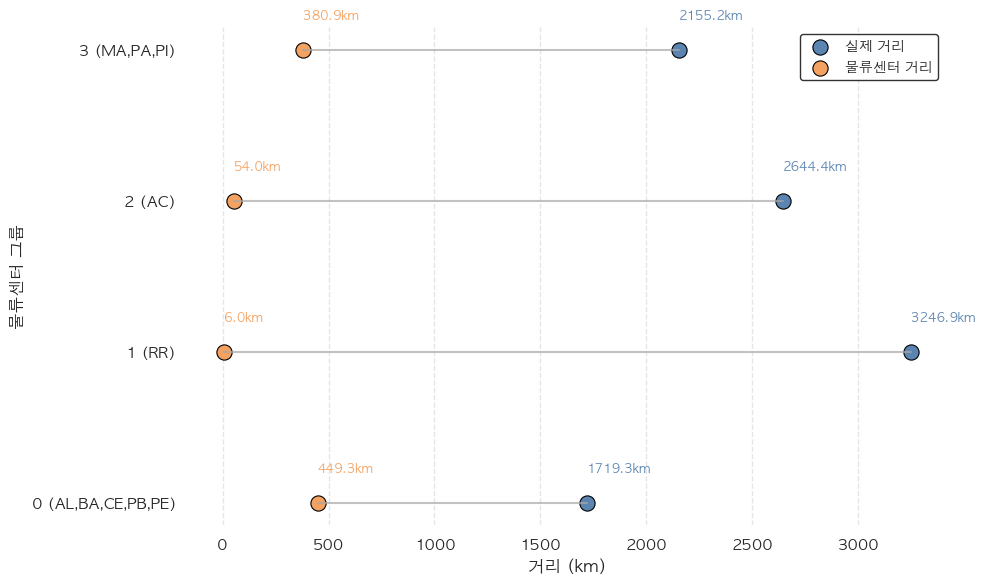

In [421]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 한글 폰트 (Mac용)
plt.rcParams['font.family'] = 'AppleGothic'
sns.set(font="AppleGothic", style="white")

# 데이터 준비
df = pd.DataFrame({
    'center_id': [0, 1, 2, 3],
    'center_states': ['AL,BA,CE,PB,PE', 'RR', 'AC', 'MA,PA,PI'],
    'avg_distance_km_seller': [1719.33, 3246.92, 2644.44, 2155.17],
    'avg_distance_km_center': [449.32, 6.01, 53.97, 380.87]
})

plt.figure(figsize=(10,6))

# 색상 정의 (진한 파스텔 느낌)
seller_color = "#5B84B1"   # 파란색 계열
center_color = "#F4A261"   # 주황색 계열
line_color = "#A8A8A8"     # 선 색

plt.figure(figsize=(10,6))

# 각 군집별 점+선
for i, row in df.iterrows():
    # 선 연결 (실제거리 ↔ 센터거리)
    plt.plot(
        [row['avg_distance_km_seller'], row['avg_distance_km_center']],
        [row['center_id'], row['center_id']],
        linestyle='-', color=line_color, alpha=0.7
    )
    # 실제 거리 점
    plt.scatter(
        row['avg_distance_km_seller'], row['center_id'],
        s=120, c=seller_color, edgecolor='black', linewidth=0.8,
        label='실제 거리' if i==0 else ""
    )
    # 센터 거리 점
    plt.scatter(
        row['avg_distance_km_center'], row['center_id'],
        s=120, c=center_color, edgecolor='black', linewidth=0.8,
        label='물류센터 거리' if i==0 else ""
    )
    
    # 라벨 점 위쪽에 표시
    plt.text(row['avg_distance_km_seller'], row['center_id']+0.2, 
             f"{row['avg_distance_km_seller']:.1f}km", color=seller_color, fontsize=9, fontweight='bold')
    plt.text(row['avg_distance_km_center'], row['center_id']+0.2, 
             f"{row['avg_distance_km_center']:.1f}km", color=center_color, fontsize=9, fontweight='bold')

# y축 라벨: 클러스터 번호 + 관할 지역
yticklabels = [f"{row['center_id']} ({row['center_states']})" for _, row in df.iterrows()]
plt.yticks(df['center_id'], yticklabels)

# 축 라벨 & 제목
plt.xlabel("거리 (km)", fontsize=12)
plt.ylabel("물류센터 그룹", fontsize=12)

# 범례 테두리
plt.legend(frameon=True, edgecolor='black', fontsize=10)

# 그리드 (세로선만 점선, 가로선 제거)
sns.despine(left=True, bottom=True)
plt.grid(axis="y", visible=False)
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


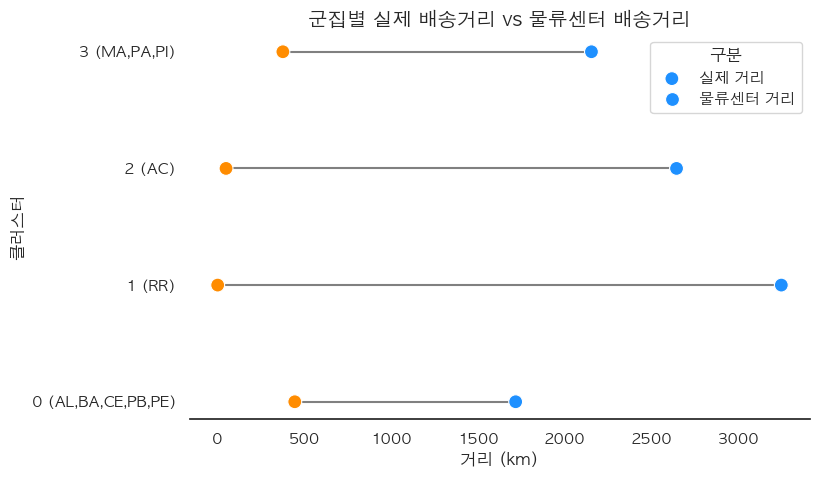

In [407]:


plt.rcParams['font.family'] = 'AppleGothic'



df = pd.DataFrame({
    'center_id': [0, 1, 2, 3],
    'center_states': ['AL,BA,CE,PB,PE', 'RR', 'AC', 'MA,PA,PI'],
    'avg_distance_km_seller': [1719.33, 3246.92, 2644.44, 2155.17],
    'avg_distance_km_center': [449.32, 6.01, 53.97, 380.87]
})

# Seaborn 스타일 설정
sns.set(font="AppleGothic", style="white")
plt.rcParams['axes.grid.axis'] = 'y'   # 세로 grid만
plt.rcParams['axes.grid'] = False      # 기본 grid 끄기

# 데이터 변환 (long format으로 바꿔서 sns에 넣기 좋게)
df_melt = df.melt(
    id_vars=['center_id', 'center_states'],
    value_vars=['avg_distance_km_seller', 'avg_distance_km_center'],
    var_name='type', value_name='distance'
)

# 색상 매핑
palette = {
    'avg_distance_km_seller': 'dodgerblue',
    'avg_distance_km_center': 'darkorange'
}

# 점 찍기
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_melt,
    x='distance', y='center_id',
    hue='type', palette=palette,
    s=100, zorder=2
)

# 각 군집별로 두 점을 선으로 연결
for _, row in df.iterrows():
    plt.plot(
        [row['avg_distance_km_seller'], row['avg_distance_km_center']],
        [row['center_id'], row['center_id']],
        color="gray", linewidth=1.5, zorder=1
    )

# y축 라벨을 "클러스터 번호 (states)" 형태로
yticks = [f"{cid} ({states})" for cid, states in zip(df['center_id'], df['center_states'])]
plt.yticks(df['center_id'], yticks)

# 제목 & 레이아웃
plt.title("군집별 실제 배송거리 vs 물류센터 배송거리", fontsize=14)
plt.xlabel("거리 (km)")
plt.ylabel("클러스터")
plt.legend(title="구분", labels=["실제 거리", "물류센터 거리"])

sns.despine(left=True, bottom=False)  # 불필요한 축 제거
plt.show()


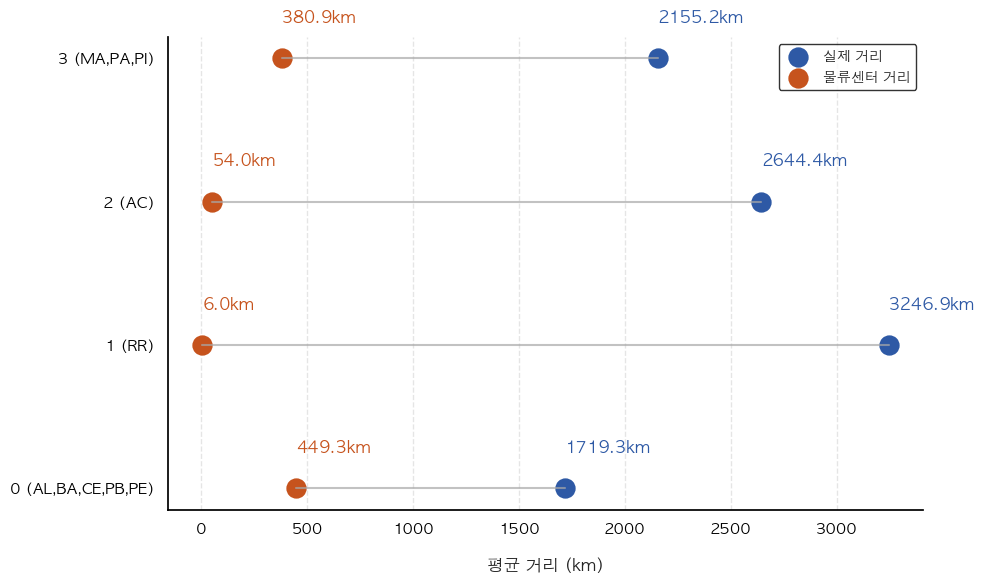

In [447]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 한글 폰트 (Mac)
plt.rcParams['font.family'] = 'AppleGothic'
sns.set(font="AppleGothic", style="white")

# 데이터 준비
df = pd.DataFrame({
    'center_id': [0, 1, 2, 3],
    'center_states': ['AL,BA,CE,PB,PE', 'RR', 'AC', 'MA,PA,PI'],
    'avg_distance_km_seller': [1719.33, 3246.92, 2644.44, 2155.17],
    'avg_distance_km_center': [449.32, 6.01, 53.97, 380.87]
})

# 색상 정의 (진한 파스텔 느낌)
seller_color = "#2E59A5"   # 파란색 계열
center_color = "#C6531D"  # 주황색 계열
line_color = "#A8A8A8"     # 선 색

plt.figure(figsize=(10,6))

# 각 군집별 점+선
for i, row in df.iterrows():
    # 선 연결 (실제거리 ↔ 센터거리)
    plt.plot(
        [row['avg_distance_km_seller'], row['avg_distance_km_center']],
        [row['center_id'], row['center_id']],
        linestyle='-', color=line_color, alpha=0.7
    )
    # 실제 거리 점
    plt.scatter(
        row['avg_distance_km_seller'], row['center_id'],
        s=180, c=seller_color, edgecolor=seller_color, linewidth=1.2,
        label='실제 거리' if i==0 else ""
    )
    # 센터 거리 점
    plt.scatter(
        row['avg_distance_km_center'], row['center_id'],
        s=180, c=center_color, edgecolor=center_color, linewidth=1.2,
        label='물류센터 거리' if i==0 else ""
    )
    
    # 라벨 점 위쪽에 표시
    plt.text(row['avg_distance_km_seller'], row['center_id']+0.25, 
             f"{row['avg_distance_km_seller']:.1f}km", color=seller_color, fontsize=12, fontweight='bold')
    plt.text(row['avg_distance_km_center'], row['center_id']+0.25, 
             f"{row['avg_distance_km_center']:.1f}km", color=center_color, fontsize=12, fontweight='bold')

# y축 라벨: 클러스터 번호 + 관할 지역
yticklabels = [f"{row['center_id']} ({row['center_states']})" for _, row in df.iterrows()]
plt.yticks(df['center_id'], yticklabels)

# 축 라벨 & 제목
plt.xlabel("평균 거리 (km)", fontsize=12, labelpad=15)
# plt.ylabel("물류센터 그룹", fontsize=12, labelpad=15)

# 틱(tick) 색과 굵기 지정
plt.xticks(color='black', fontweight='bold')
plt.yticks(color='black', fontweight='bold')

# 범례 테두리
plt.legend(frameon=True, edgecolor='black', fontsize=10)

# 그리드 (세로선만 점선, 가로선 제거)
sns.despine(left=True, bottom=True)
plt.grid(axis="y", visible=False)
plt.grid(axis="x", linestyle="--", alpha=0.5)


# 축선 다시 그리기 (검정색, 굵기)
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')





plt.tight_layout()
# 그래프 저장 (고해상도)
plt.savefig("delivery_distance_graph.png", dpi=300, bbox_inches='tight')

plt.show()



In [5]:
## kaggel에서 브라질 인구 데이터 (외부 데이터 불러오기) : 2019년 기준..
# https://www.kaggle.com/datasets/thiagobodruk/brazilianstates?resource=download
states = pd.read_csv('states.csv')
states.head(10)

UF             State     Capital       Region         Area  Population  \
0  AC              Acre  Rio Branco        North   164123.738      881935   
1  AL           Alagoas      Maceió    Northeast    27843.295     3337357   
2  AM          Amazonas      Manaus        North  1559168.117     4144597   
3  AP             Amapá      Macapá        North   142470.762      845731   
4  BA             Bahia    Salvador    Northeast   564722.611    14873064   
5  CE             Ceará   Fortaleza    Northeast   148894.757     9132078   
6  DF  Distrito Federal    Brasília  Center-west     5760.783     3015268   
7  ES    Espírito Santo     Vitória    Southeast    46074.444     4018650   
8  GO             Goiás     Goiânia  Center-west   340125.715     7018354   
9  MA          Maranhão    São Luís    Northeast   329642.170     7075181   

   Demographic Density  Cities count       GDP  GDP rate  Poverty  Latitude  \
0                 5.37            22  17201.95       0.5    0.189     -8.77   
1               119.86           102  15653.51       0.5    0.205     -9.62   
2                 2.66            62  22936.28       0.7    0.193     -3.47   
3                 5.94            16  19405.11       0.6    0.128      1.41   
4                26.34           417  17508.67       0.6    0.177    -13.29   
5                61.33           184  16394.99       0.5    0.184     -5.20   
6               523.41             1  80502.47       2.5    0.019    -15.83   
7                87.22            78  28222.56       0.9    0.043    -19.19   
8                20.63           246  28308.77       0.9    0.037    -15.98   
9                21.46           217  12788.75       0.4    0.263     -5.42   

   Longitude  
0     -70.55  
1     -36.82  
2     -65.10  
3     -51.77  
4     -41.71  
5     -39.53  
6     -47.86  
7     -40.34  
8     -49.86  
9     -45.44

In [15]:
# 1️⃣ 주별 고유 구매자 수 계산
buyers_per_state = orders_data.groupby('customer_state')['customer_id'].nunique().reset_index()
buyers_per_state.rename(columns={'customer_id':'num_buyers'}, inplace=True)

# 2️⃣ states 데이터와 병합
state_buyers = pd.merge(buyers_per_state, states[['UF', 'Population']], 
                        left_on='customer_state', right_on='UF', how='left')

# 3️⃣ 구매자 대비 인구 비율 계산
state_buyers['buyer_ratio'] = state_buyers['num_buyers'] / state_buyers['Population']

# 4️⃣ 결과 확인
state_buyers[['customer_state', 'num_buyers', 'Population', 'buyer_ratio']].sort_values('Population', ascending=False)

customer_state  num_buyers  Population  buyer_ratio
25             SP       40247    45919049     0.000876
10             MG       11273    21168791     0.000533
18             RJ       12196    17264943     0.000706
4              BA        3221    14873064     0.000217
17             PR        4889    11433957     0.000428
22             RS        5320    11377239     0.000468
15             PE        1575     9557071     0.000165
5              CE        1268     9132078     0.000139
13             PA         931     8602865     0.000108
23             SC        3519     7164788     0.000491
9              MA         708     7075181     0.000100
8              GO        1937     7018354     0.000276
2              AM         144     4144597     0.000035
7              ES        1963     4018650     0.000488
14             PB         510     4018127     0.000127
19             RN         469     3506853     0.000134
12             MT         877     3484466     0.000252
1              AL         393     3337357     0.000118
16             PI         468     3273227     0.000143
6              DF        1908     3015268     0.000633
11             MS         699     2778986     0.000252
24             SE         333     2298696     0.000145
20             RO         240     1777225     0.000135
26             TO         272     1572866     0.000173
0              AC          80      881935     0.000091
3              AP          66      845731     0.000078
21             RR          41      605761     0.000068

In [17]:
# 인구 대비 구매자 비율(buyer_ratio)

# 4️⃣ 브라질 주 경계 GeoJSON
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
geo_data = requests.get(url).json()

# 5️⃣ 지도 생성
m_buyer_ratio = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# 6️⃣ Choropleth
folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=state_buyers,
    columns=['customer_state', 'buyer_ratio'],
    key_on='feature.properties.sigla',   # GeoJSON의 주 코드 컬럼
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='인구 대비 구매자 비율',
    nan_fill_color='white'
).add_to(m_buyer_ratio)

folium.LayerControl().add_to(m_buyer_ratio)

# 7️⃣ 지도 출력
m_buyer_ratio

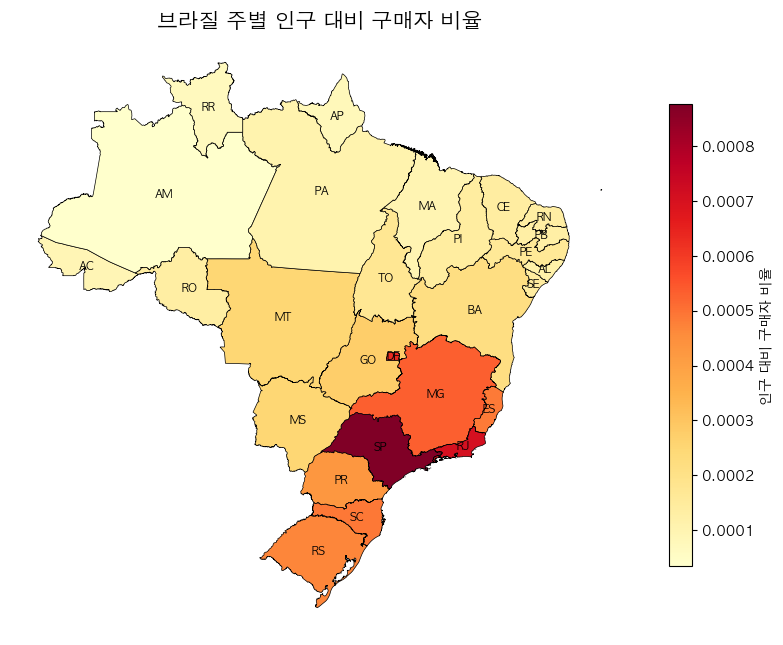

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1️⃣ 브라질 주 경계 GeoJSON 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brazil = gpd.read_file(geo_url)

# 2️⃣ 인구 대비 구매자 비율 데이터 merge
# state_buyers: customer_state, buyer_ratio 컬럼 존재
brazil = brazil.merge(state_buyers, left_on='sigla', right_on='customer_state', how='left')

# 3️⃣ 시각화
fig, ax = plt.subplots(figsize=(10, 10))
brazil.plot(
    column='buyer_ratio',   # 색칠할 값
    cmap='YlOrRd',          # 색상
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "인구 대비 구매자 비율", 'shrink': 0.6},
    ax=ax
)

# 4️⃣ 주 코드 표시 (중앙값 기준)
for idx, row in brazil.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['sigla'], ha='center', va='center', fontsize=8, fontweight='bold')

plt.title("브라질 주별 인구 대비 구매자 비율", fontsize=15)
plt.axis('off')
plt.savefig("인구대비 구매자 비율.png", dpi=300, bbox_inches='tight',  transparent=True)
plt.show()


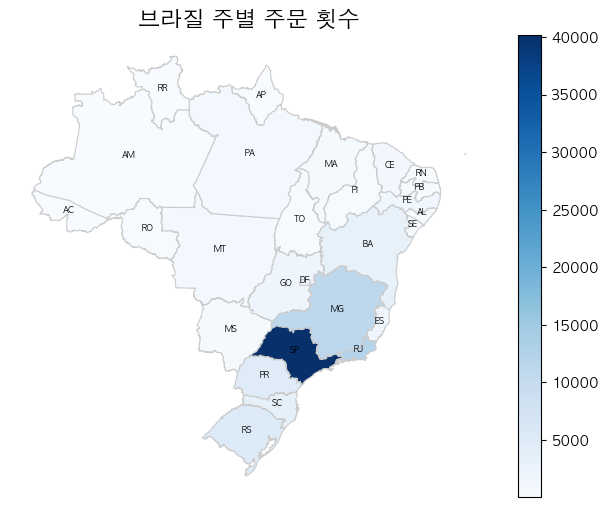

In [53]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ 브라질 주 경계 GeoJSON 불러오기
geo_path = '/Users/jeonseoyeong/Desktop/fastcampus/패스트캠퍼스 부트캠프 (sql)/팀플/brazil-states.geojson'
gdf = gpd.read_file(geo_path)

# 2️⃣ 주문 데이터 준비 (예: state_summary 데이터프레임)
# state_summary: index=customer_state, columns=['order_count']
# index를 column으로 풀기
df = state_summary.reset_index()

# 3️⃣ GeoDataFrame과 merge
# GeoJSON에 있는 주 코드 컬럼명 확인 필요 (sigla, name 등)
merged = gdf.merge(df, left_on="sigla", right_on="customer_state", how="left")

# 4️⃣ Choropleth 시각화
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
merged.plot(
    column="order_count", 
    cmap="Blues",   # 🔵 파란색 계열 (연한→진한)
    linewidth=0.8, 
    ax=ax, 
    edgecolor="0.8", 
    legend=True
)

# 4️⃣ 주 이름 표시 (중심 좌표 기준)
for idx, row in gdf.iterrows():
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
             row['sigla'], 
             horizontalalignment='center', 
             fontsize=6, fontweight='bold', color='black')

ax.set_title("브라질 주별 주문 횟수", fontsize=16)
ax.axis("off")
plt.savefig("인구대비 구매자 비율.png", dpi=300, bbox_inches='tight',  transparent=True)
plt.show()


In [33]:
# 주별 요약 (전체 데이터)
state_summary = items_merged_data.groupby('customer_state').agg(
    order_count=('order_id', 'nunique'),
    avg_price=('price', 'mean'),
    avg_freight=('freight_value', 'mean'),
    avg_weight=('product_weight_g', 'mean'),
    avg_volume=('volume', 'mean'),
    avg_distance=('distance_km', 'mean')
).sort_values('avg_freight', ascending=False)

state_summary

order_count   avg_price  avg_freight   avg_weight  \
customer_state                                                      
RR                       41  153.423261    43.088043  1854.217391   
PB                      506  190.028383    43.040278  2216.406957   
RO                      239  168.309145    41.337175  2379.498141   
AC                       79  174.799667    40.199333  1953.177778   
PI                      468  161.721725    39.244012  2374.346899   
MA                      707  145.530428    38.504950  1959.387909   
TO                      271  156.416678    37.546906  2581.410423   
SE                      333  149.420672    36.061102  2310.354839   
AL                      393  181.458782    35.708970  1936.524590   
RN                      469  157.239556    35.621004  1770.243243   
PA                      931  164.666102    35.527045  2187.104909   
AP                       66  166.611375    34.281500  1874.162500   
AM                      144  135.838957    33.321166  1553.282209   
CE                     1265  153.921881    32.751611  2009.271824   
PE                     1574  144.562271    32.717781  1925.572911   
MT                      874  147.153959    28.054858  2244.061584   
BA                     3211  134.203172    26.473776  2243.526460   
MS                      697  142.118364    23.258352  2305.633700   
GO                     1933  125.123670    22.703799  1939.626779   
ES                     1958  117.062626    21.932315  2088.348402   
RS                     5307  118.462498    21.587573  2052.812052   
SC                     3510  122.849813    21.501393  2120.594495   
DF                     1905  125.364028    21.086151  1697.518349   
RJ                    12159  123.973279    20.888656  2246.804102   
MG                    11245  119.864215    20.602544  2157.893943   
PR                     4877  118.239726    20.504755  2041.410740   
SP                    40173  109.134398    15.111511  2029.525749   

                  avg_volume  avg_distance  
customer_state                              
RR              15716.000000   3246.918055  
PB              16507.398261   2096.967604  
RO              14610.821561   2225.991765  
AC              12948.466667   2644.435479  
PI              15402.428295   1958.970774  
MA              15127.964736   2103.857883  
TO              17608.257329   1481.718753  
SE              17658.155914   1652.285564  
AL              14234.018735   1835.066497  
RN              13228.486486   2099.155772  
PA              15385.376323   2291.828412  
AP              11613.962500   2590.119994  
AM              12064.730061   2643.746677  
CE              14500.518098   2189.630330  
PE              13995.858213   1973.516943  
MT              15634.140762   1350.623533  
BA              15555.898273   1343.612796  
MS              16661.443223    845.510893  
GO              14308.806940    774.939933  
ES              14632.950228    802.487730  
RS              15641.813518    867.407997  
SC              15804.049644    572.126680  
DF              12935.562844    830.379260  
RJ              15540.586478    487.650854  
MG              15003.137625    534.028654  
PR              15201.479374    487.493456  
SP              15140.317557    247.732058

In [31]:

# 1️⃣ 고객 정보 병합 (위도/경도, 도시, 주 포함)
items_merged_data = items_data.merge(
    orders_data[['order_id', 'customer_lat', 'customer_lng', 'customer_city', 'customer_state']],
    on='order_id',
    how='left'
)

# 2️⃣ null값 제거
items_merged_data = items_merged_data.dropna(subset=['seller_lat', 'seller_lng', 'customer_lat', 'customer_lng', 'customer_city', 'customer_state'])

# # 3️⃣ 거리 계산 (haversine)
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # 지구 반경 (km)
    return c * r

items_merged_data['distance_km'] = haversine(
    items_merged_data['seller_lat'],
    items_merged_data['seller_lng'],
    items_merged_data['customer_lat'],
    items_merged_data['customer_lng']
)

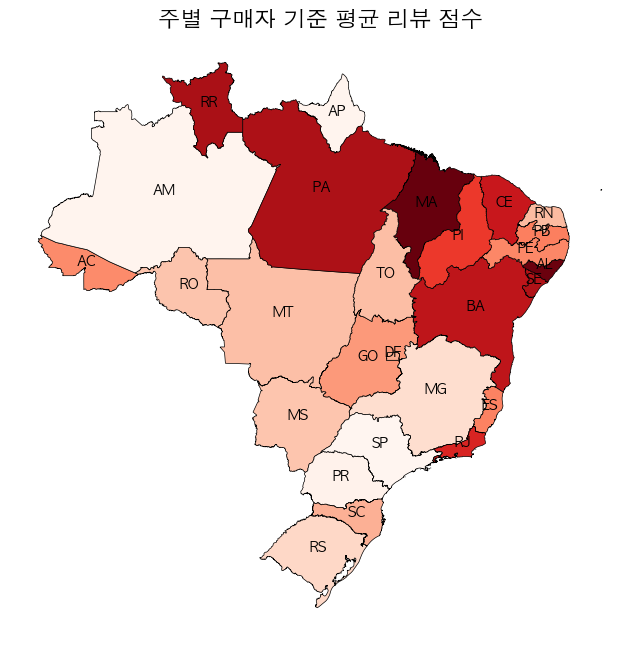

In [47]:

# =====================
# 1️⃣ 원본 보존
# =====================
orders = orders_data.copy()
items = items_data.copy()

# =====================
# 2️⃣ 거리 계산 (상품 단위)
# =====================
def haversine_distance(lat1, lng1, lat2, lng2):
    R = 6371  # 지구 반경 (km)
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# 고객 위경도 붙이기
items = items.merge(
    orders[['order_id','customer_lat','customer_lng']],
    on='order_id', how='left'
)

# 거리 계산
items['distance_km'] = haversine_distance(
    items['seller_lat'], items['seller_lng'],
    items['customer_lat'], items['customer_lng']
)

# =====================
# 3️⃣ 주문 단위 집계
# =====================
# (1) 거리 - max / mean
order_distance_max = items.groupby('order_id')['distance_km'].max().rename('order_distance_km_max')
order_distance_mean = items.groupby('order_id')['distance_km'].mean().rename('order_distance_km_mean')

# (2) 주문별 배송비 총합
order_freight_sum = items.groupby('order_id')['freight_value'].sum().rename('order_freight_sum')

# (3) 대표 판매자 주 (가장 빈번한 state)
seller_state_mode = items.groupby('order_id')['seller_state'] \
                        .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan) \
                        .rename('seller_state')
# 주문 단위 대표 판매자 위도/경도 (mode)
seller_lat_mode = items.groupby('order_id')['seller_lat'] \
                       .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan) \
                       .rename('seller_lat')
seller_lng_mode = items.groupby('order_id')['seller_lng'] \
                       .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan) \
                       .rename('seller_lng')
# =====================
# 4️⃣ 배송기간 & 지연 플래그
# =====================)

# 배송기간 (일 단위)
orders['delivery_days'] = (orders['order_delivered_date'] - orders['order_approved_date']).dt.days
orders['delivery_delay_days'] = (orders['order_delivered_date'] - orders['order_estimated_date']).dt.days


# =====================
# 5️⃣ 최종 Merge
# =====================
# 기존 merge에 추가
orders_enriched = (
    orders
    .merge(order_distance_max.reset_index(), on='order_id', how='left')
    .merge(order_distance_mean.reset_index(), on='order_id', how='left')
    .merge(order_freight_sum.reset_index(), on='order_id', how='left')
    .merge(seller_state_mode.reset_index(), on='order_id', how='left')
    .merge(seller_lat_mode.reset_index(), on='order_id', how='left')
    .merge(seller_lng_mode.reset_index(), on='order_id', how='left')
)

# =====================
# 6️⃣ 결과 확인
# =====================
orders_enriched.head(10)


# 1️⃣ 브라질 주 경계 GeoJSON 불러오기
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(geo_url)

# 2️⃣ orders_enriched 기준 평균 리뷰 점수 merge
state_avg_review = orders_enriched.groupby('customer_state')['avg_review_score'].mean().reset_index()
state_avg_review.rename(columns={'customer_state':'sigla', 'avg_review_score':'avg_review_score'}, inplace=True)

gdf = gdf.merge(state_avg_review, on='sigla', how='left')

# 3️⃣ 지도 그리기 (컬러 막대 제거)
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf.plot(column='avg_review_score', 
         cmap='Reds_r',    # 낮은 점수 진하게
         legend=False,     # 컬러 막대 제거
         edgecolor='black',
         linewidth=0.5,
         ax=ax)

# 4️⃣ 주 이름 표시 (중심 좌표 기준)
for idx, row in gdf.iterrows():
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
             row['sigla'], 
             horizontalalignment='center', 
             fontsize=10, fontweight='bold', color='black')

plt.title('주별 구매자 기준 평균 리뷰 점수', fontsize=16)
plt.axis('off')
plt.savefig("평균 리뷰 점수.png", dpi=300, bbox_inches='tight',  transparent=True)
plt.show()



/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1233/2683203563.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["delivery_delay_days"] > 0).mean() * 100)  # 지연율(%)


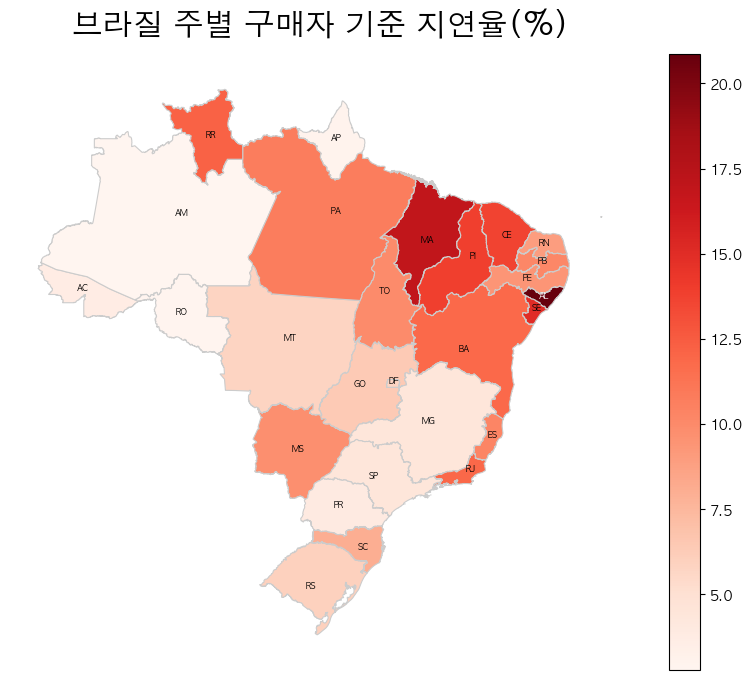

In [71]:
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ 구매자 기준 지연율 계산
# -----------------------------
customer_delay_rate = (
    orders_enriched
    .groupby("customer_state")
    .apply(lambda x: (x["delivery_delay_days"] > 0).mean() * 100)  # 지연율(%)
    .reset_index(name="delay_rate")
)

# -----------------------------
# 2️⃣ 브라질 주 경계 GeoDataFrame
# -----------------------------
geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
brazil_gdf = gpd.read_file(geojson_url)

# -----------------------------
# 3️⃣ merge + NaN 처리
# -----------------------------
brazil_customer = brazil_gdf.merge(customer_delay_rate, left_on="sigla", right_on="customer_state", how="left")
brazil_customer["delay_rate"] = brazil_customer["delay_rate"].fillna(0)

# -----------------------------
# 4️⃣ 지도 시각화
# -----------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.axis("off")

brazil_customer.plot(
    column="delay_rate",
    cmap="Reds",          # 🔴 지연율 높을수록 진한 빨강
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=ax
)

ax.set_title("브라질 주별 구매자 기준 지연율(%)", fontdict={"fontsize":22}, pad=20)

# -----------------------------
# 5️⃣ 라벨 추가
# -----------------------------
brazil_customer["coords"] = brazil_customer["geometry"].apply(lambda x: x.representative_point().coords[:])
brazil_customer["coords"] = [coords[0] for coords in brazil_customer["coords"]]

for idx, row in brazil_customer.iterrows():
    ax.text(
        row["coords"][0], row["coords"][1],
        f"{row['sigla']}",   # 주이름만 표시
        horizontalalignment="center",
        fontsize=6,
        weight="bold",
        color="black" if row["delay_rate"] < 20 else "white"
    )


plt.savefig("주별 지연율.png", dpi=300, bbox_inches='tight',  transparent=True)
plt.show()


## 추가적

In [12]:
orders_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95547 entries, 0 to 95546
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  95547 non-null  object        
 1   order_status              95547 non-null  object        
 2   order_approved_date       95547 non-null  datetime64[ns]
 3   order_delivered_date      95547 non-null  datetime64[ns]
 4   order_estimated_date      95547 non-null  datetime64[ns]
 5   customer_id               95547 non-null  object        
 6   customer_zip_code_prefix  95547 non-null  object        
 7   customer_lat              95547 non-null  float64       
 8   customer_lng              95547 non-null  float64       
 9   customer_city             95547 non-null  object        
 10  customer_state            95547 non-null  object        
 11  total_item_price          95547 non-null  float64       
 12  total_freight     

In [28]:
# 클러스터 3 해당 state 선택
cluster3_orders = orders_enriched[orders_enriched['customer_state'].isin(['MA','PA','PI'])]

# 총 기존 배송 거리 합
total_distance_cluster3 = cluster3_orders['order_distance_km_sum'].sum()

# 거리 절감률
distance_reduction_rate = 0.82  # 82%

# 1km당 평균 배송비 (BRL)
avg_cost_per_km = 0.03337061670283227

# 절감액 계산
total_cost_saved_cluster3 = total_distance_cluster3 * distance_reduction_rate * avg_cost_per_km

print(f"클러스터 3 예상 배송비 절감액: {total_cost_saved_cluster3:.2f} BRL")


# 총 주문금액
total_order_price_cluster3 = cluster3_orders['order_total_price'].sum()

# 총 운송비
total_freight_cluster3 = cluster3_orders['total_freight'].sum()

print(f"클러스터 3 총 주문금액: {total_order_price_cluster3:,.2f} BRL")
print(f"클러스터 3 총 운송비: {total_freight_cluster3:,.2f} BRL")

클러스터 3 예상 배송비 절감액: 138237.65 BRL
클러스터 3 총 주문금액: 369,845.85 BRL
클러스터 3 총 운송비: 87,454.55 BRL


In [20]:
avg_cost_per_km = orders_enriched['total_freight'].sum() / orders_enriched['order_distance_km_sum'].sum()
avg_cost_per_km

0.03337061670283227

In [30]:
import pandas as pd

# 클러스터 정의
clusters = {
    "0": ["AL", "BA", "CE", "PB", "PE"],
    "1": ["RR"],
    "2": ["AC"],
    "3": ["MA", "PA", "PI"]
}

# 예시 거리 절감율
distance_saving = {
    "0": 0.74,
    "1": 0.99,
    "2": 0.98,
    "3": 0.82
}

# 클러스터별 요약 계산
cluster_summary = []

for c, states in clusters.items():
    cluster_df = orders_enriched[orders_enriched['customer_state'].isin(states)]
    
    total_order_amount = cluster_df['order_total_price'].sum()
    total_freight = cluster_df['order_freight_sum'].sum()
    
    # 거리 절감 기준 절감액 (Upper Bound)
    upper_bound_saving = total_freight * distance_saving[c]
    
    # 현실적 절감액 (50~70% 범위, 여기선 60% 적용)
    realistic_saving = upper_bound_saving * 0.6
    
    cluster_summary.append({
        "클러스터": c,
        "관할 주": ", ".join(states),
        "거리 절감율": distance_saving[c],
        "총 주문금액(BRL)": total_order_amount,
        "총 운송비(BRL)": total_freight,
        "예상 절감액 Upper Bound(BRL)": upper_bound_saving,
        "현실적 절감액(BRL)": realistic_saving
    })

# 데이터프레임으로 정리
cluster_summary_df = pd.DataFrame(cluster_summary)
print(cluster_summary_df)


  클러스터                관할 주  거리 절감율  총 주문금액(BRL)  총 운송비(BRL)  \
0    0  AL, BA, CE, PB, PE    0.74   1143834.66   239437.32   
1    1                  RR    0.99      7057.47     1982.05   
2    2                  AC    0.98     15731.97     3617.94   
3    3          MA, PA, PI    0.82    369845.85    87676.95   

   예상 절감액 Upper Bound(BRL)  현실적 절감액(BRL)  
0              177183.6168  106310.17008  
1                1962.2295    1177.33770  
2                3545.5812    2127.34872  
3               71895.0990   43137.05940  


In [32]:
import pandas as pd

# 클러스터 정의
clusters = {
    "0": ["AL", "BA", "CE", "PB", "PE"],
    "1": ["RR"],
    "2": ["AC"],
    "3": ["MA", "PA", "PI"]
}

# 거리 절감율
distance_saving = {
    "0": 0.74,
    "1": 0.99,
    "2": 0.98,
    "3": 0.82
}

# 현실적 절감 비율 (50~70% 구간, 여기서는 60% 적용)
realistic_ratio = 0.6

# 신규 유입 가정치 (배송 개선으로 고객 증가율, 예시 10%)
new_customer_rate = 0.10

# 재구매율 개선 가정치 (배송 개선으로 재구매율 증가, 예시 5%)
repeat_rate_increase = 0.05

cluster_summary = []

for c, states in clusters.items():
    cluster_df = orders_enriched[orders_enriched['customer_state'].isin(states)]
    
    # 총 주문금액 및 총 운송비
    total_order_amount = cluster_df['order_total_price'].sum()
    total_freight = cluster_df['order_freight_sum'].sum()
    
    # 거리 절감 기준 절감액 (Upper Bound)
    upper_bound_saving = total_freight * distance_saving[c]
    
    # 현실적 절감액
    realistic_saving = upper_bound_saving * realistic_ratio
    
    # 신규 고객 유입 시 매출 영향
    new_customer_sales = total_order_amount * new_customer_rate
    
    # 재구매율 향상 시 매출 영향
    repeat_customer_sales = total_order_amount * repeat_rate_increase
    
    # 총 예상 매출 증가
    total_sales_impact = new_customer_sales + repeat_customer_sales + realistic_saving
    
    cluster_summary.append({
        "클러스터": c,
        "관할 주": ", ".join(states),
        "거리 절감율": distance_saving[c],
        "총 주문금액(BRL)": total_order_amount,
        "총 운송비(BRL)": total_freight,
        "예상 절감액 Upper Bound(BRL)": upper_bound_saving,
        "현실적 절감액(BRL)": realistic_saving,
        "신규 고객 매출 증가(BRL)": new_customer_sales,
        "재구매 매출 증가(BRL)": repeat_customer_sales,
        "총 예상 매출 영향(BRL)": total_sales_impact
    })

cluster_summary_df = pd.DataFrame(cluster_summary)
print(cluster_summary_df)


  클러스터                관할 주  거리 절감율  총 주문금액(BRL)  총 운송비(BRL)  \
0    0  AL, BA, CE, PB, PE    0.74   1143834.66   239437.32   
1    1                  RR    0.99      7057.47     1982.05   
2    2                  AC    0.98     15731.97     3617.94   
3    3          MA, PA, PI    0.82    369845.85    87676.95   

   예상 절감액 Upper Bound(BRL)  현실적 절감액(BRL)  신규 고객 매출 증가(BRL)  재구매 매출 증가(BRL)  \
0              177183.6168  106310.17008        114383.466      57191.7330   
1                1962.2295    1177.33770           705.747        352.8735   
2                3545.5812    2127.34872          1573.197        786.5985   
3               71895.0990   43137.05940         36984.585      18492.2925   

   총 예상 매출 영향(BRL)  
0     277885.36908  
1       2235.95820  
2       4487.14422  
3      98613.93690  


In [34]:
import pandas as pd

# orders_enriched 복사
df = orders_enriched.copy()

# order_approved_date 기준으로 반기(H1/H2) 생성
df['half'] = df['order_approved_date'].dt.to_period('6M')  # 6개월 단위

# 고객별 첫 주문일 기준
first_order = df.sort_values('order_approved_date').groupby('customer_id')['order_approved_date'].first().reset_index()

# 고객별 반기 정보 추가
first_order['half'] = first_order['order_approved_date'].dt.to_period('6M')

# state 정보 가져오기
first_order = first_order.merge(df[['customer_id','customer_state']], on='customer_id', how='left').drop_duplicates()

# 반기별 state별 신규 고객 수
state_new_customers = first_order.groupby(['customer_state','half'])['customer_id'].nunique().reset_index()
state_new_customers.rename(columns={'customer_id':'new_customers'}, inplace=True)

state_new_customers.sort_values(['customer_state','half'])


customer_state     half  new_customers
0               AC  2017-01              2
1               AC  2017-02              3
2               AC  2017-03              2
3               AC  2017-04              5
4               AC  2017-05              8
..             ...      ...            ...
551             TO  2018-04             19
552             TO  2018-05             16
553             TO  2018-06             18
554             TO  2018-07             21
555             TO  2018-08             14

[556 rows x 3 columns]

/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1752848360.py:17: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1752848360.py:17: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1752848360.py:17: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1752848360.py:17: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1752848360.py:17: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1752848360.py:17: UserWarnin

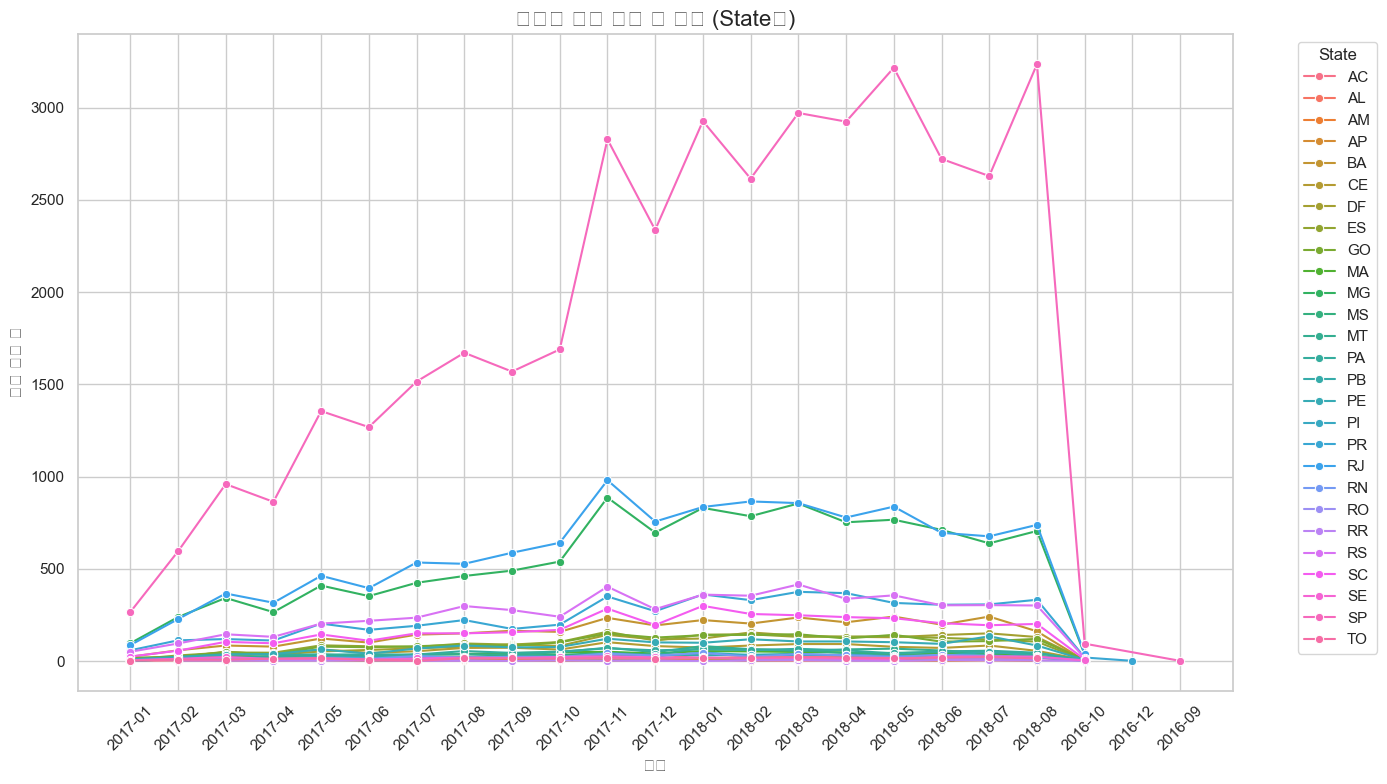

In [38]:
# half 컬럼을 문자열로 변환
state_new_customers['half_str'] = state_new_customers['half'].astype(str)

plt.figure(figsize=(14,8))
sns.lineplot(
    data=state_new_customers,
    x='half_str',       # 변환한 문자열 컬럼 사용
    y='new_customers',
    hue='customer_state',
    marker='o'
)
plt.title('반기별 신규 고객 수 추이 (State별)', fontsize=16)
plt.xlabel('반기', fontsize=12)
plt.ylabel('신규 고객 수', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1690010731.py:58: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1690010731.py:58: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1690010731.py:58: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1690010731.py:58: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1690010731.py:58: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/1690010731.py:58: UserWarnin

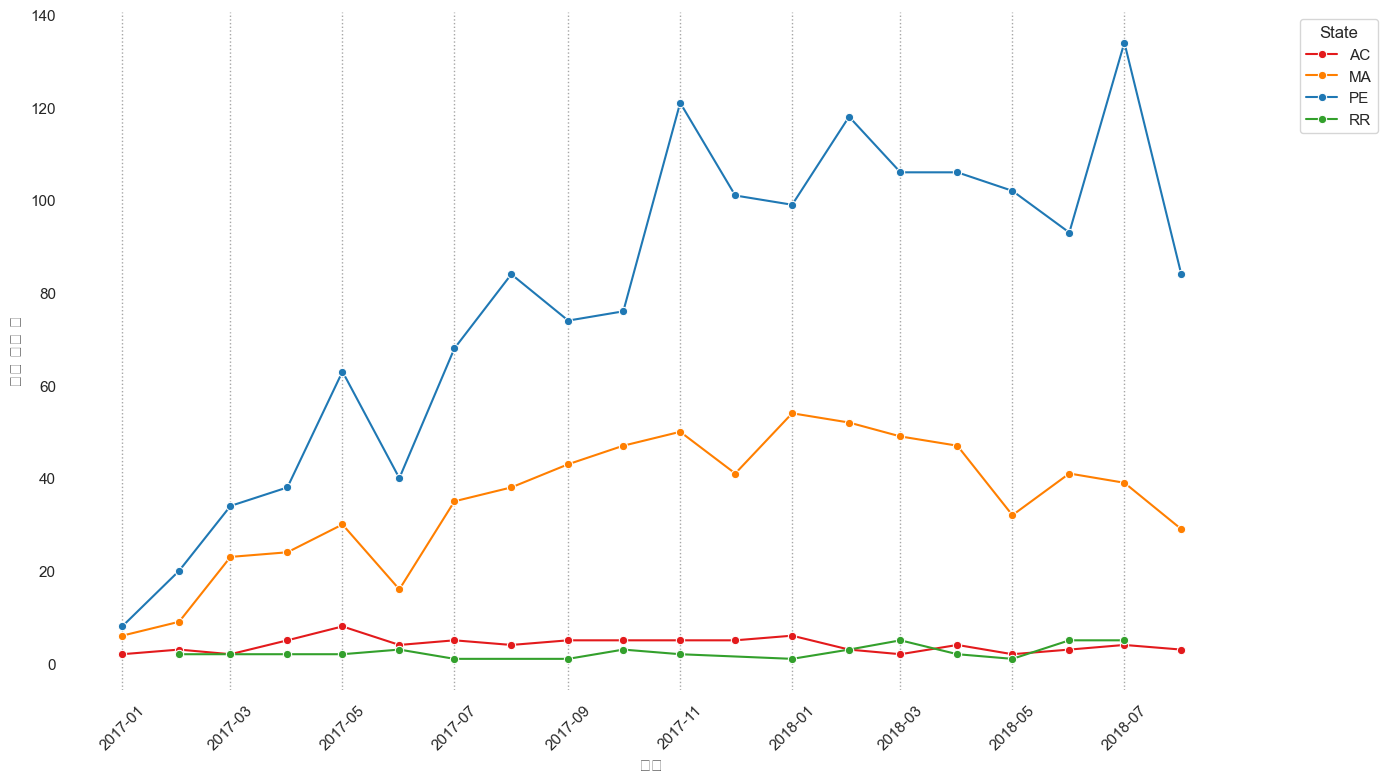

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 분석할 주 리스트
target_states = ['RR','MA','AC','PE']
df_filtered = orders_enriched[orders_enriched['customer_state'].isin(target_states)].copy()

# 주문 승인일 기준으로 반기(Half-Year) 생성
df_filtered['half'] = df_filtered['order_approved_date'].dt.to_period('6M').dt.start_time

# 반기별 신규 고객 수 계산
state_new_customers = (
    df_filtered.groupby(['customer_state','half'])['customer_id']
    .nunique()
    .reset_index(name='new_customers')
)

# 원하는 기간으로 필터링
start_date = '2017-01-01'
end_date = '2018-08-31'
state_new_customers = state_new_customers[
    (state_new_customers['half'] >= start_date) &
    (state_new_customers['half'] <= end_date)
]

# 색상 지정
state_colors = {
   'PE': "#1F78B4",
  'RR': "#33A02C",
  'AC': "#E31A1C",
  'MA': "#FF7F00"
}

# 시각화
plt.figure(figsize=(14,8))
sns.lineplot(
    data=state_new_customers,
    x='half',
    y='new_customers',
    hue='customer_state',
    marker='o',
    palette=state_colors
)

# x축 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 레이블 및 그리드
plt.xlabel('반기', fontsize=12)
plt.ylabel('신규 고객 수', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle=':', color='gray', alpha=0.7)
plt.grid(axis='y', visible=False)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [ ]:
“저희는 물류센터 후보군 10개를 K-means 군집 분석을 통해 4개의 최종 허브 위치로 압축했습니다. 선정된 PE, RR, AC, MA 지역은 단순히 군집 분석 결과뿐만 아니라, 기존 주문 데이터에서 배송 지연율과 주문 수, 구매 단가 등 물류 효율성을 고려한 후보군과도 일치합니다.

추가로, 각 지역의 신규 고객 유입 추이를 분석한 결과, PE와 MA는 신규 고객 유입이 상대적으로 높아, 물류센터 신설 시 고객 기반 확대와 매출 증가 효과도 기대할 수 있습니다. 반면, RR과 AC는 신규 유입은 적지만 기존 고객의 배송 지연률이 높고, 지리적 격차가 크기 때문에 소형 허브 배치를 통해 배송 품질 개선과 전체 물류망 효율화에 기여할 수 있습니다.

즉, K-means 분석과 기존 물류 데이터, 그리고 고객 유입 현황까지 종합했을 때, PE, RR, AC, MA 지역은 물류센터 입지로 매우 적합하다고 판단됩니다.”

/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/2232895940.py:62: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/2232895940.py:62: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/2232895940.py:62: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/2232895940.py:62: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/2232895940.py:62: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/2232895940.py:62: UserWarnin

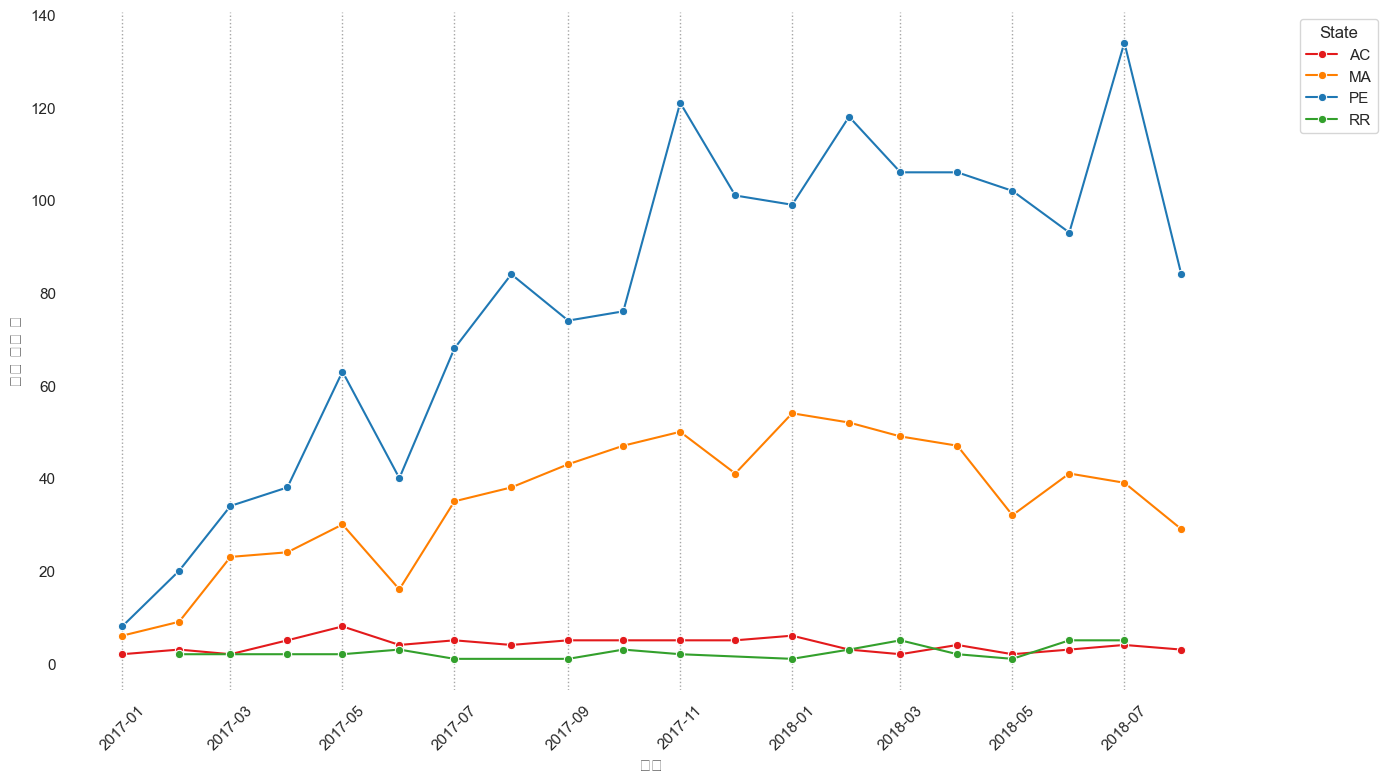

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 분석할 주 리스트
target_states = ['RR','MA','AC','PE']
df_filtered = orders_enriched[orders_enriched['customer_state'].isin(target_states)].copy()

# 주문 승인일 기준으로 반기(Half-Year) 생성
df_filtered['half'] = df_filtered['order_approved_date'].dt.to_period('6M').dt.start_time

# 반기별 신규 고객 수 계산
state_new_customers = (
    df_filtered.groupby(['customer_state','half'])['customer_id']
    .nunique()
    .reset_index(name='new_customers')
)

# 원하는 기간으로 필터링
start_date = '2017-01-01'
end_date = '2018-08-31'
state_new_customers = state_new_customers[
    (state_new_customers['half'] >= start_date) &
    (state_new_customers['half'] <= end_date)
]

# 색상 지정
state_colors = {
   'PE': "#1F78B4",  # 연한 파랑
   'RR': "#33A02C",  # 연한 초록
   'AC': "#E31A1C",  # 연한 빨강
   'MA': "#FF7F00"   # 연한 오렌지
}

# 시각화
plt.figure(figsize=(14,8))
sns.lineplot(
    data=state_new_customers,
    x='half',
    y='new_customers',
    hue='customer_state',
    marker='o',
    palette=state_colors
)

# x축 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 레이블 설정
plt.xlabel('반기', fontsize=12)
plt.ylabel('신규 고객 수', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그리드: 세로 점선만
plt.grid(axis='x', linestyle=':', color='gray', alpha=0.7)
plt.grid(axis='y', visible=False)

# 테두리 제거
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig("신규고객_2017-2018.png", dpi=300, bbox_inches='tight')
plt.show()


/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/884649570.py:69: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/884649570.py:69: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/884649570.py:69: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/884649570.py:69: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/884649570.py:69: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1312/884649570.py:69: UserWarning: Gly

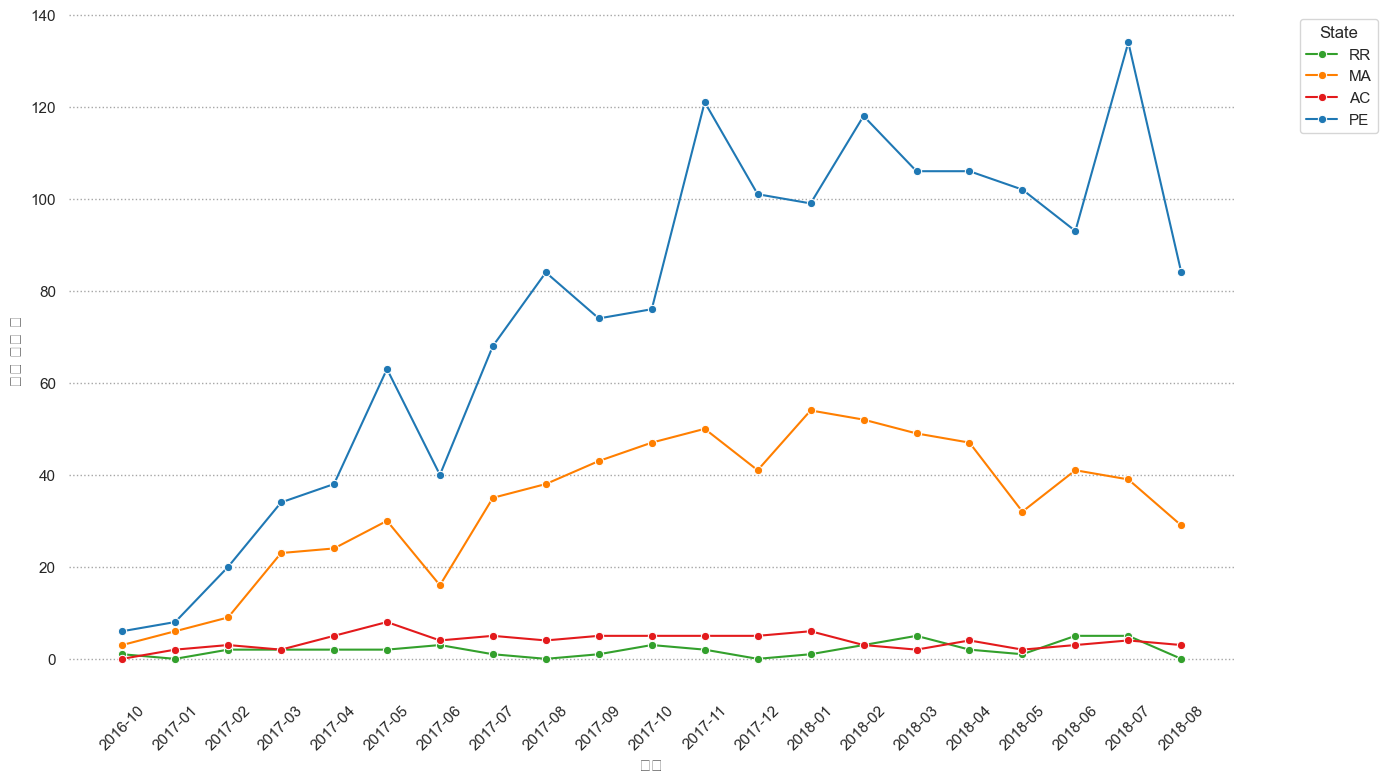

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 분석할 주 리스트
target_states = ['RR','MA','AC','PE']

# 대상 주만 필터링
df_filtered = orders_enriched[orders_enriched['customer_state'].isin(target_states)].copy()

# 주문 승인일 기준으로 반기(Half-Year) 생성
df_filtered['half'] = df_filtered['order_approved_date'].dt.to_period('6M')

# 이전에 등장한 고객 추적용 집합
seen_customers = set()
new_customers_list = []

# 반기 순서대로 정렬
df_filtered = df_filtered.sort_values('order_approved_date')

for half_period, group in df_filtered.groupby('half'):
    # 현재 반기 고객
    current_customers = set(group['customer_id'])
    # 신규 고객 = 이전에 본 적 없는 고객
    new_customers = current_customers - seen_customers
    # 결과 저장
    for state in target_states:
        count = group[group['customer_state']==state]['customer_id'].isin(new_customers).sum()
        new_customers_list.append({'half': half_period, 'customer_state': state, 'new_customers': count})
    # 이미 본 고객 업데이트
    seen_customers.update(current_customers)

# DataFrame 생성
state_new_customers = pd.DataFrame(new_customers_list)
state_new_customers['half_str'] = state_new_customers['half'].astype(str)

# 색상 지정
state_colors = {
   'PE': "#1F78B4",
  'RR': "#33A02C",
  'AC': "#E31A1C",
  'MA': "#FF7F00"
}

# 시각화
plt.figure(figsize=(14,8))
sns.lineplot(
    data=state_new_customers,
    x='half_str',
    y='new_customers',
    hue='customer_state',
    marker='o',
    palette=state_colors
)

# 레이블 설정
plt.xlabel('반기', fontsize=12)
plt.ylabel('신규 고객 수', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# 점선 그리드
plt.grid(axis='y', linestyle=':', color='gray', alpha=0.7)
plt.grid(axis='x', visible=False)

# 테두리 제거
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
